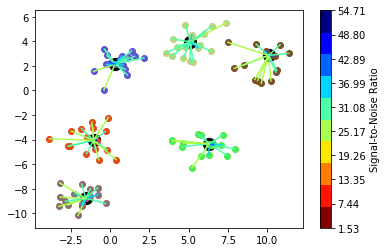

0.7444057464599609
{'Cluster Head': 'client79', 'Members': ['client17', 'client29', 'client31', 'client38', 'client41', 'client42', 'client46', 'client51', 'client54', 'client59', 'client66', 'client74', 'client81', 'client86', 'client100'], 'SNR': [22.46801607796755, 50.44336695034113, 22.39805113386536, 25.728046662460066, 25.579349448331342, 37.1974161839223, 39.61409798780832, 28.633037596874516, 21.463601830541343, 28.11592367687481, 22.212503572435498, 22.356380934143147, 25.609054408615968, 23.68805113281762, 26.039933728853946], 'CSI': [0.3434644028898256, 0.9251144847679822, 0.3108591569407042, 0.8922709091448932, 0.9690991279341928, 0.3680864215995503, 0.586159441679657, 0.014899832457164974, 0.9980699970435281, 0.18205997097683368, 0.21188325903905458, 0.2645570940042743, 0.8676792017628533, 0.0787573690107165, 0.5261816906856017]}


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
from utils import averageModelscluster
import random
import math
import matplotlib.pyplot as plt
from ipynb.fs.full.K_clusters import cluster_former
from copy import deepcopy

In [2]:
P=2 #signal power threshold
#stream = BitStream()
#random.seed(10)
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 50
        self.rounds = 200
        self.epochs = 5
        self.local_batches = 64
        self.lr = 0.01
        self.C = 1 #fraction of clients used in the round
        self.drop_rate = 0 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'iid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.numclusters=3

args = Arguments()

In [4]:
#checking if gpu is available
#use_cuda = args.use_cuda and torch.cuda.is_available()
use_cuda=False
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
me = hook.local_worker
clients = []

#generating virtual clients
for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
#print(clients)

In [5]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average


In [6]:
#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform)
# global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [7]:
"""class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 50) #10 iid #50 non iid
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10
                   )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) """

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
def fedprox(params,global_params):
    global_param=[]
    ind=0
    for gp in global_params:
        global_param.append(gp)
    for p in params:
    #                 print(p.grad)
        lr=0.01
        mu=0.1
        if(p.grad is None):
            continue
        grad=p.grad.data #batch gradients
        p.data.sub_(lr,(grad+mu*(p.data.clone()-global_param[ind].data.clone())))
        ind+=1
    return(p)

In [9]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu,head):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    head['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                #client['optim'].zero_grad()
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                client['optim'].step()
                params=client['model'].parameters()
                gp=head['model'].parameters()
                #params=fedprox(params,gp) 
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get()
    head['model'].get()
    # print()
         #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [10]:
def test(args, model, device, test_loader, name,fed_round):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda and fed_round==0):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return([100. * correct / len(test_loader.dataset),test_loss])

In [11]:
torch.manual_seed(args.torch_seed)

In [12]:
def distort(neighbours,snrs):
    ind=0
    poptim=2
    csi=random.random()
    distorted_models=[]
    for client in neighbours:
        snr=snrs[ind]
        ind+=1
        snr__=10**(snr/10)
        absh=csi*poptim/snr__
        x=random.uniform(0,absh)
        y=math.sqrt(absh*absh-x*x)
        std=math.sqrt(poptim/snr__*absh*absh) #channel noise
        h=complex(x,y)
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
        
        distorted_models.append(client)
    return(distorted_models)
        

In [13]:
def decentralized(clients,snrs,weights):
    big_daddy_of_distorted_models=[]
    for client in clients:
        distorted_models=[]
        snr_list=[]
        for snr in snrs:
            if(client['hook'].id in snr):
                snr_list.append(snr[2])
        neighbours_c = [x for x in clients if x != client]
        neighbours={}
        jjj=[jkl for jkl in range(len(neighbours_c))]
        
        dictionary = dict(zip(jjj, neighbours_c))
        #for jjj in range(len(neighbours_c)):
        #   neighbours[jjj].append(neighbours_c[jjj])
        distorted_models=distort(neighbours,snr_list)
        distorted_models.append(client)
        big_daddy_of_distorted_models.append(distorted_models)
    
    
    weight_final1=[]
    for oho in big_daddy_of_distorted_models:
        weight_final=[]
        for comeon in oho:
            for w in weights:
                if(comeon['hook'].id==w[0]):
                    weight_final.append(w[1])
        weight_final1.append(weight_final)
    
    final_heads=[]
    nets=[]
    ind=0
    for client in clients:
        for oof in big_daddy_of_distorted_models:
            if(client==oof[0]):
#                 print(client)
#                 print("shut up")
#                 print(distorted_models)
#                 print("shut up")
#                 print(weight_final1)
                
                overall=Net()
                overall=averageModelscluster(overall,distorted_models,weight_final1[ind])
                client['model'].load_state_dict(overall.state_dict())
                ind+=1
                final_heads.append(client)
                nets.append(overall)
    
    return(final_heads,nets)
        
            
            

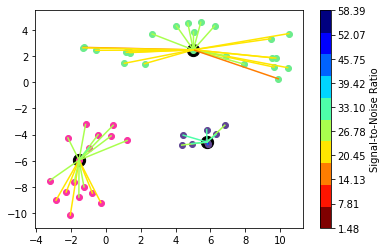

0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309830


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.224918
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.760412
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.264207
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.227408

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.324184
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.237081
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.763917
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.229636
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.803287

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.320533
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.178844
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.456086
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.202990
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.149822
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.433899
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.386494
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.158872

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301476
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.189962
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.703395
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.278054
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.225023

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302040
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300314
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.835630
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.288604
Model client44 Train Epoch: 5 

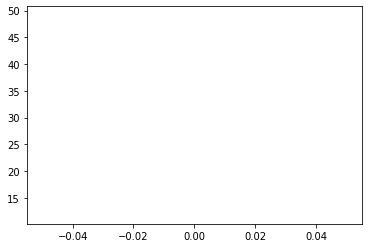

ROUND 0
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301992


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.229534
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.388458
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.485870
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.600738

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306302
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.229496
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.880241
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.650463
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.905302

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.314730
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.022048
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.648794
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.531421
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.157108
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.931884
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.797013
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.090931

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.312201
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.899996
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.824264
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.490158
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.725717

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296252
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.132458
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.611537
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.780834
Model client44 Train Epoch: 5 

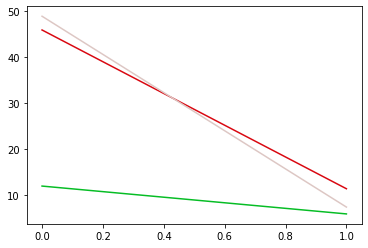

ROUND 1
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.321908


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.172993
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.283130
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.287844
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.394879

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299637
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.283897
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.185821
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.423938
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.361320

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.320650
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299452
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.530746
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.484375
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.111247
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.945297
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.288816
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306352

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303800
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321923
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.315334
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328618
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.318176

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.342599
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.005292
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.269964
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.915302
Model client44 Train Epoch: 5 

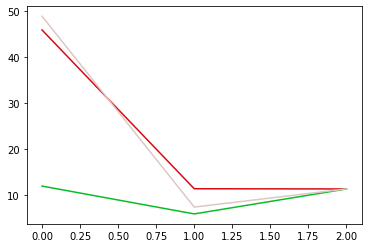

ROUND 2
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303764


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322747
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299188
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310273
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326439

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295520
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290299
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.281351
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.270008
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.366358

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303721
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308276
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316594
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.307147
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323140
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323102
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317680
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302995

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307767
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312855
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.307110
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.299916
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.339939

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305143
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295967
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.342411
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.305246
Model client44 Train Epoch: 5 

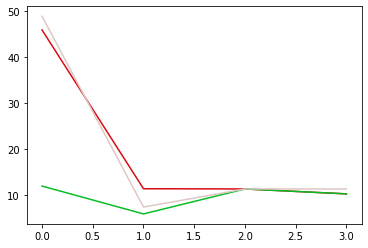

ROUND 3
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300932


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287468
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316906
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.324959
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295051

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298850
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295836
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299948
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308777
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306517

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297282
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294977
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.288905
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328259
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297081
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.221555
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301294
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.235371

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302768
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294972
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.324354
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.331609
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295794

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302922
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303233
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.331682
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301922
Model client44 Train Epoch: 5 

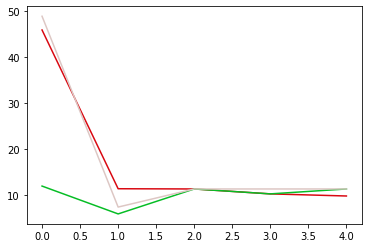

ROUND 4
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303222


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310408
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.294453
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.319069
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.373596

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304874
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292829
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.292923
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.287869
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.329162

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298716
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311167
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312464
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.257142
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314875
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298478
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.300359
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297833

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304980
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303416
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290959
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.281704
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.290926

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306810
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299654
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314804
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.316555
Model client44 Train Epoch: 5 

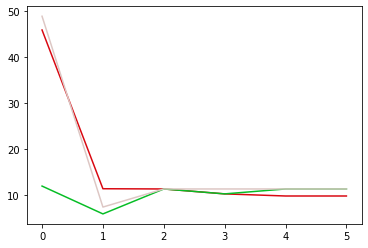

ROUND 5
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307232


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303433
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.315540
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.410737
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.320210

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306100
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298592
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326411
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.300721
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302839

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302497
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299605
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.283377
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.283902
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305606
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.297579
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330790
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310837

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302243
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297743
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326716
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.291259
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.298769

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305470
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288927
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.324049
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.309964
Model client44 Train Epoch: 5 

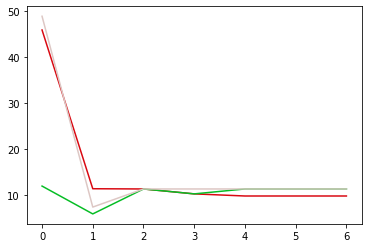

ROUND 6
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298255


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295220
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.285257
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.286972
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.274942

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301523
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303488
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.289661
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.299437
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291832

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305711
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293669
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299566
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323782
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295498
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.329144
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.309949
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.280861

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299747
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294052
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.319429
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.305046
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.300290

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302553
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312975
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.281305
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.299154
Model client44 Train Epoch: 5 

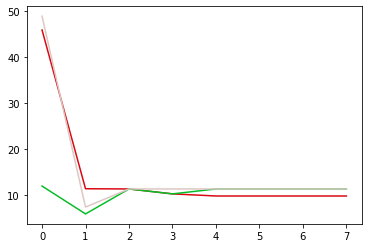

ROUND 7
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306458


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325540
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291623
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317615
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297237

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300108
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311687
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.335019
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312312
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310030

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304542
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309545
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316017
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.258605
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295862
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312906
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301027
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.324501

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299125
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305791
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.297439
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.292687
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.321504

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302133
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292168
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293096
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.265043
Model client44 Train Epoch: 5 

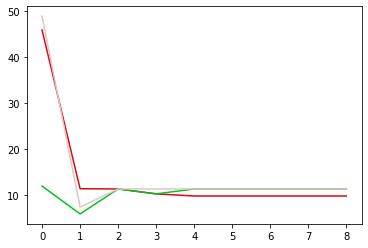

ROUND 8
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298720


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.283278
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.336478
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.346332
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316955

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305544
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285254
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312285
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.314483
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303695

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304996
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309319
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.321490
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.359039
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301669
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.307207
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.320091
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291718

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300300
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299581
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.309502
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.297247
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.344820

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298467
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299386
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305425
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.290531
Model client44 Train Epoch: 5 

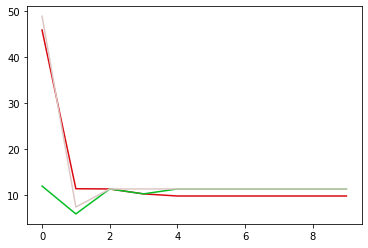

ROUND 9
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301536


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319542
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.301877
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.327387
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.311222

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301949
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307845
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313931
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.293338
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.276313

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303059
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299292
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.265549
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.324484
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301226
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.321491
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.306532
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.290309

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308423
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307660
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306054
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308811
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316976

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302928
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289680
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.269513
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.331171
Model client44 Train Epoch: 5 

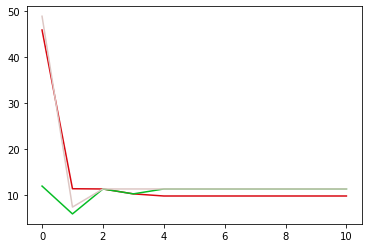

ROUND 10
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309057


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310900
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306037
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323007
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.272890

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304469
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.306218
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313258
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.300610
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.276735

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298936
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301684
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.269656
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.313782
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308728
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.289987
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.287544
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306540

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306959
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298585
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.282388
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.326177
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.257553

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302011
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300704
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.300997
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337373
Model client44 Train Epoch: 5 

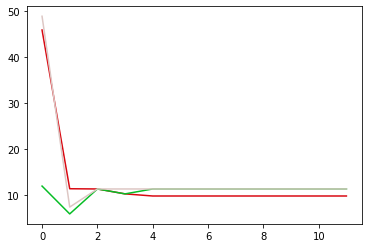

ROUND 11
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297797


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292569
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.310138
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.275627
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.272402

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303152
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288340
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.301930
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.298946
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.293113

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303378
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.276072
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.328160
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.322479
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298750
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.295570
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301243
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322805

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301006
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310699
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290654
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.284446
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.331331

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301663
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.271548
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.264584
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329059
Model client44 Train Epoch: 5 

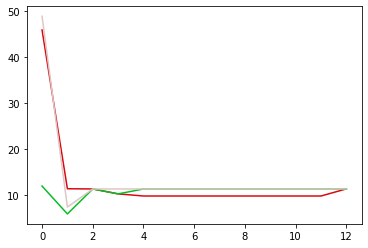

ROUND 12
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294233


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305924
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378700
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.300389
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.290255

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298935
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295077
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323612
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323313
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.352525

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295385
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299461
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322246
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.256383
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288561
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.320695
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.322306
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322648

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.313077
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297829
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317580
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317260
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.294696

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309323
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302807
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322860
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.332689
Model client44 Train Epoch: 5 

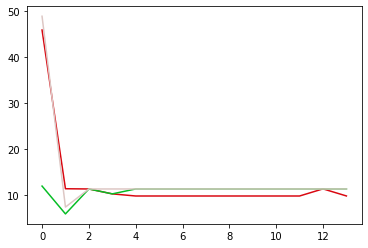

ROUND 13
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301216


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296881
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.294920
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.316373
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.274370

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298372
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317130
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339741
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317281
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.337598

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301740
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287485
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323346
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.290129
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309986
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302539
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310718
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306386

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297948
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323140
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327160
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317219
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292293

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303836
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323340
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305744
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329771
Model client44 Train Epoch: 5 

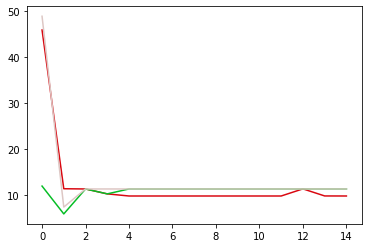

ROUND 14
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293854


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309681
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.325042
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.299392
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292070

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300516
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307964
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305250
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.289769
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.337597

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304118
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334245
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293082
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.303521
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303636
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298052
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.327606
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.323420

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299879
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319609
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.295613
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.333788
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.309363

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298605
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298506
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.342407
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.286817
Model client44 Train Epoch: 5 

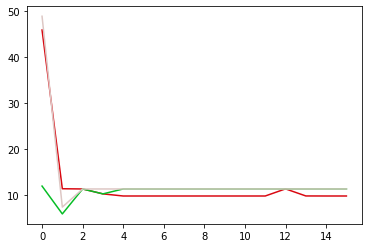

ROUND 15
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302718


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317617
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.282476
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.332508
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.298769

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308416
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287204
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.287801
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.307238
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.287833

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304176
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328227
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.300608
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.249569
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308644
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303586
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308169
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.321980

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301150
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304024
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303489
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.303361
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313879

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302196
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321820
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313333
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.341733
Model client44 Train Epoch: 5 

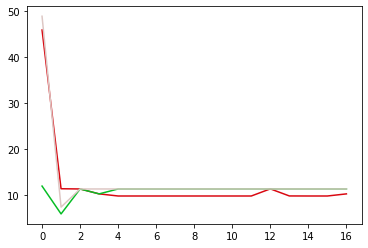

ROUND 16
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297918


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.279270
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296044
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.309795
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314863

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302162
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323632
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.334550
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.309897
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313168

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304312
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305038
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.315313
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.331600
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317795
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290356
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.314907
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302916

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300299
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295421
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.325540
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.332563
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.289334

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302022
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293221
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.357934
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.331544
Model client44 Train Epoch: 5 

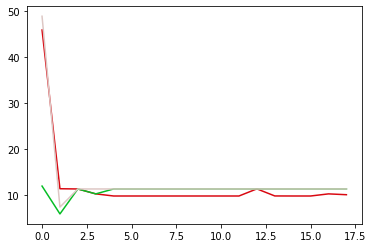

ROUND 17
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309742


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298247
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318577
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.304681
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322969

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300214
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303799
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.304334
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.336210
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.336007

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299541
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310241
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316319
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.289465
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313039
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318016
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.299438
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.283242

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301100
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304592
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.315499
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.320034
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334132

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297341
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293867
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.319631
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.374539
Model client44 Train Epoch: 5 

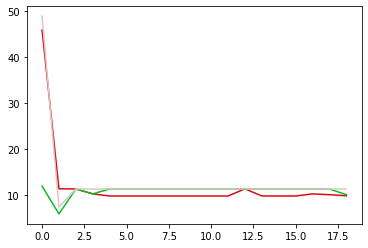

ROUND 18
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299026


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310596
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.286156
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.285495
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.289831

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302351
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301666
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316607
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310128
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.285472

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300979
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315011
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322675
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.344987
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298661
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.271143
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325752
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.296420

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308584
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301333
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296798
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.344380
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.328796

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304890
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319506
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.335116
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.320947
Model client44 Train Epoch: 5 

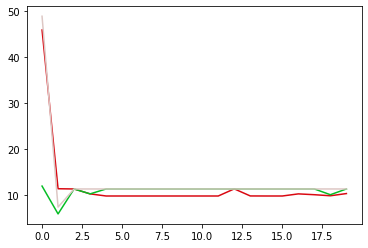

ROUND 19
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297904


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300567
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.275789
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.287565
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.332575

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305439
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300571
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302985
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.338193
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306268

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298949
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.280994
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.367329
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325880
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307522
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.294618
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.334694
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.287602

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305436
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319910
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313246
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.287905
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.324982

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299403
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286417
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.329718
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.293403
Model client44 Train Epoch: 5 

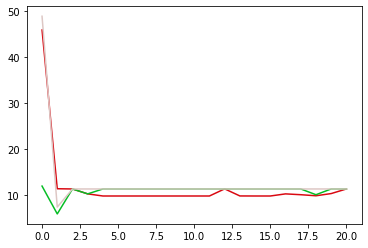

ROUND 20
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301403


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307236
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.263499
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.349506
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304430

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302899
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308306
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.328425
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310051
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310327

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299237
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321456
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.284163
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.346621
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288779
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326037
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.299758
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.294713

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303905
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.266319
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.350110
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.286443
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297329

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306718
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286717
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.334999
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.290212
Model client44 Train Epoch: 5 

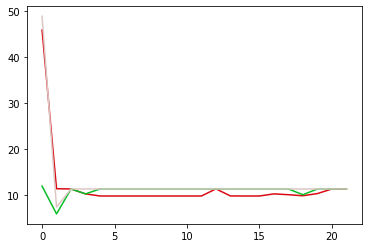

ROUND 21
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299142


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303442
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314813
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.318961
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310520

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305351
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287107
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327982
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.249027
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.318097

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301451
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.277155
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316756
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308901
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304351
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.328732
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.320603
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.287533

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308204
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305950
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316579
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.293932
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.288439

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300764
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.275010
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.320401
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310484
Model client44 Train Epoch: 5 

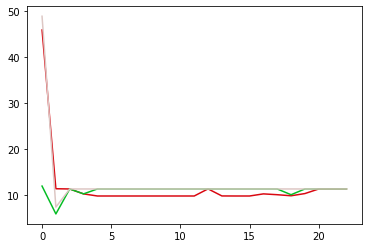

ROUND 22
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305155


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305243
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317584
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323298
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.294745

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308136
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292198
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.331346
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.294362
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.269495

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301677
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317405
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306460
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.305608
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317482
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318529
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308780
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314945

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304937
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308192
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.301420
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.313901
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322426

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305658
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301219
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302109
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.333956
Model client44 Train Epoch: 5 

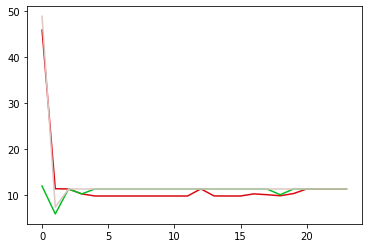

ROUND 23
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295513


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310313
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313089
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.284540
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.296553

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299816
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288002
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303413
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.281730
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.287369

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298962
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307271
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308439
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.327420
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303462
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306432
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.287161
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.305900

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299186
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317792
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.324919
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.290628
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292258

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307749
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307141
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.351998
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.345150
Model client44 Train Epoch: 5 

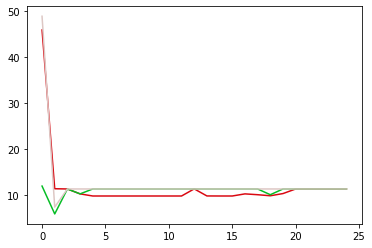

ROUND 24
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307213


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292714
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.334246
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.343335
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302771

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302134
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300641
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.276078
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.320963
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.265929

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302716
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327260
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.297800
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308458
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304479
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303935
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.307043
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.312704

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303823
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296798
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322220
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.346005
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313344

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298650
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305977
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.273381
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.321586
Model client44 Train Epoch: 5 

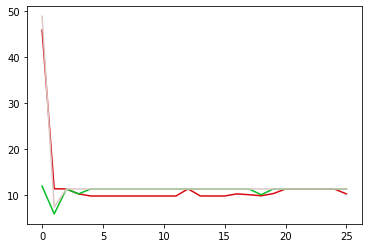

ROUND 25
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302750


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310144
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291105
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.295571
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306926

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305576
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320224
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.266545
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.266951
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.308358

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291428
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327369
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.324885
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.303118
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.283419
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305663
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.295594
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295671

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300322
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287621
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.334510
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.338812
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.328130

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307291
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.340824
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327848
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329433
Model client44 Train Epoch: 5 

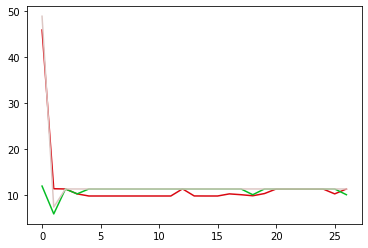

ROUND 26
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305457


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296106
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316193
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317352
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.285973

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298265
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305373
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.243359
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.292851
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299277

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.311099
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.277768
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.358948
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.304533
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298488
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.297598
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330058
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.296272

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295033
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292983
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.324205
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.284544
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291304

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299842
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327868
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.366048
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.279106
Model client44 Train Epoch: 5 

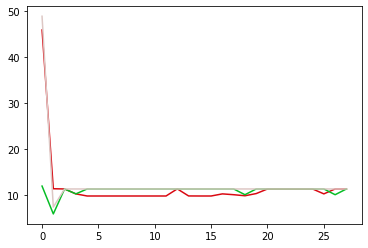

ROUND 27
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302062


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316559
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.253867
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328816
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304703

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302650
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317274
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318160
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.307300
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334471

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305950
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320851
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323346
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.347157
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287993
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.310188
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.292963
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302620

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303275
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.335261
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316775
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.362183
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292214

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301063
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327303
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308722
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.346492
Model client44 Train Epoch: 5 

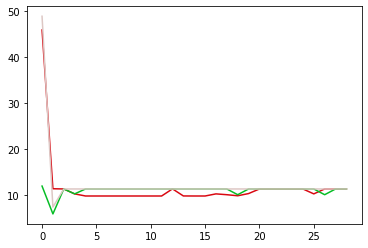

ROUND 28
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297733


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320102
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.320492
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.315831
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.344571

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308603
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.324472
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318851
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301614
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322926

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308023
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321229
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.309805
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.350859
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286808
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.282025
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.302869
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302868

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302490
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313410
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293568
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.340140
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.287173

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297434
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328133
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.403897
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.357063
Model client44 Train Epoch: 5 

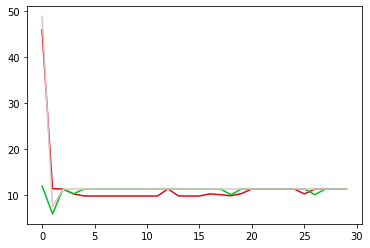

ROUND 29
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296428


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303502
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323168
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.290021
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.325054

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302656
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.339420
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322996
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.332905
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.321988

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302229
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303190
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.382057
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.297701
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299920
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303265
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312973
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.284311

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298986
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304838
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290102
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328361
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317560

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304144
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302800
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327883
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323036
Model client44 Train Epoch: 5 

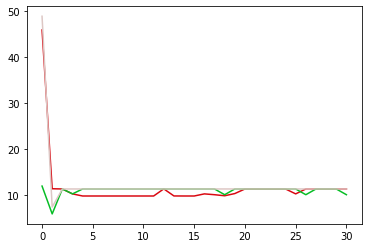

ROUND 30
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304405


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308142
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326317
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.320566
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.324764

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299192
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304215
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.361378
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.375344
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.301340

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303175
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.356994
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318862
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.292922
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303578
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318574
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.293651
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317419

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302070
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.331477
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.247503
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.292626
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.247353

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295459
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315872
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.366665
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.336626
Model client44 Train Epoch: 5 

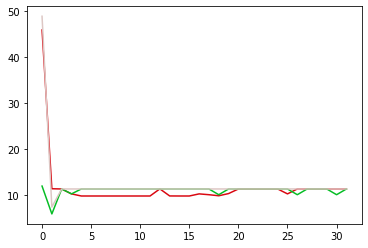

ROUND 31
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301727


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.274627
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.315936
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.294530
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306552

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305701
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317210
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314001
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.345069
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.308481

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304694
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322816
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293245
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.340873
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299705
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.285503
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310658
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302482

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300371
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317029
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.357853
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.319001
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313672

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299347
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.363648
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.390733
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.341049
Model client44 Train Epoch: 5 

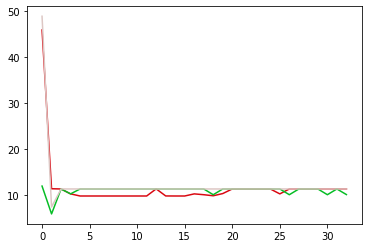

ROUND 32
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301675


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293461
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.301111
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.364614
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.286722

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304487
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.331578
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.347137
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.289096
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.333020

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302569
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300751
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314104
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.320979
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308188
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316614
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311747
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.308007

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300707
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.283199
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.297011
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.360599
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313081

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300595
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322692
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.362804
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.463454
Model client44 Train Epoch: 5 

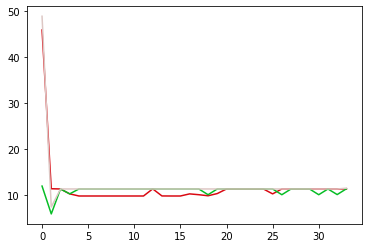

ROUND 33
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300675


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323593
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302516
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.260116
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306270

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304083
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290732
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.288042
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.324970
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297606

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300864
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319540
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314861
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.338570
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310174
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293601
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325497
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313059

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301196
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316203
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327340
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323239
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322043

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306454
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.279328
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.369580
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.345608
Model client44 Train Epoch: 5 

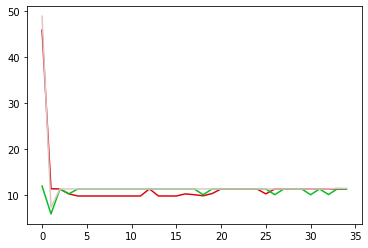

ROUND 34
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302506


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319850
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.340112
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.343277
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.330539

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304847
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322578
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308168
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.342367
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.403493

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296701
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317404
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327573
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.341129
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316745
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.285049
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.279986
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.309225

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305142
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.326657
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.365474
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.349994
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.276321

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300445
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.329167
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330600
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.352374
Model client44 Train Epoch: 5 

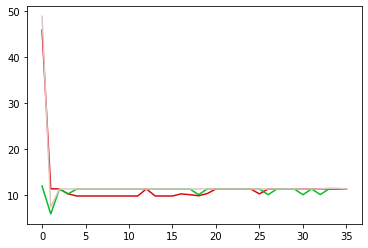

ROUND 35
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298056


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310411
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.367401
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.291292
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303046

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305667
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309665
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.368051
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.332227
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.270059

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305397
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310857
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.346746
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.387178
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303838
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298174
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.318443
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.309006

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308874
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307246
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308211
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.305056
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297484

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304170
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.252216
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311684
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.360947
Model client44 Train Epoch: 5 

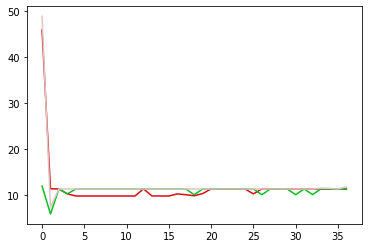

ROUND 36
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304749


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286799
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.338869
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.352696
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306583

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300197
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316668
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.292992
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.339082
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316897

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303652
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319486
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.373312
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.292011
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298608
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317240
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.283194
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326675

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300062
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.332497
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.320371
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.341944
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.338017

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302209
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319267
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318862
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.385288
Model client44 Train Epoch: 5 

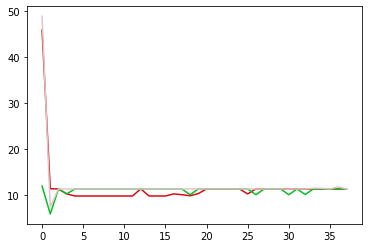

ROUND 37
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303035


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304710
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.356897
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.392572
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.278069

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295282
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305818
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.284747
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310802
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.357844

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303750
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305614
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.377655
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311363
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.283674
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322843
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.295276
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317293

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298868
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314038
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323398
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.374349
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.329320

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305145
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322958
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308472
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.358611
Model client44 Train Epoch: 5 

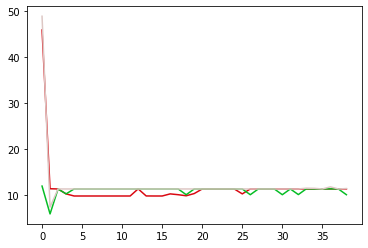

ROUND 38
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302362


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292819
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.335941
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.339610
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.279486

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297085
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318689
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.359604
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.283319
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.349754

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309277
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.282574
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291476
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.333764
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289720
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313495
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.320671
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306025

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306798
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291189
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.336289
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.347925
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.288161

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304737
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318565
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.350318
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.334114
Model client44 Train Epoch: 5 

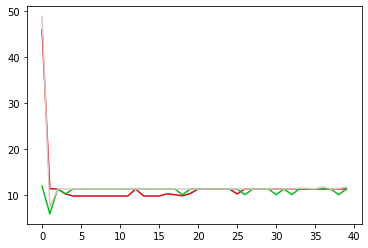

ROUND 39
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306615


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310637
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323220
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.242718
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314398

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299014
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.254504
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.363081
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.333626
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.394191

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296932
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.331392
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.350952
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.345178
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305654
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314585
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.303653
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.294942

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298218
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316065
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.355938
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.342011
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.329820

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295421
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.347161
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.380226
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.324861
Model client44 Train Epoch: 5 

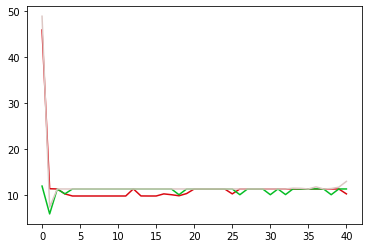

ROUND 40
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298124


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288811
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.341466
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.277820
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.353837

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303938
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290866
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322488
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329948
Model client9 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.345836

Power Allocated= 0
CSI= 0.08232820773276639
SNR= 45.50891139395367
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 10.975826056716556
CSI= 0.9691247874926395
SNR= 29.206335

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321720
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326746
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.304056
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.301096

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304212
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300971
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326318
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.336778
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.339982

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302607
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308709
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.261221
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.401089
Model client44 Train Epoch: 5 

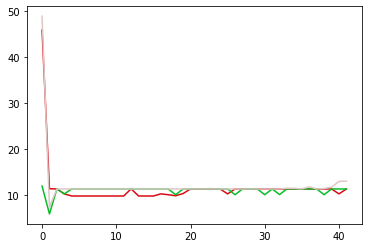

ROUND 41
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302225


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300339
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.346184
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.276191
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.321238

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300471
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.306013
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.285248
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.368955
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334984

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298743
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.341024
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312447
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.353164
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311409
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311391
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.289733
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.329214

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302534
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318104
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.309945
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337544
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.338814

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298095
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.275159
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.377056
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.439549
Model client44 Train Epoch: 5 

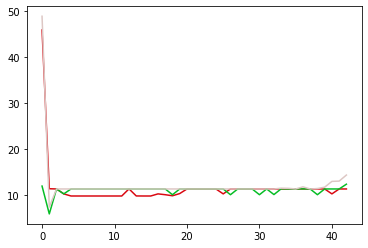

ROUND 42
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303727


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311425
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.294506
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325898
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334142

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301404
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317655
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.363044
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.365655
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.343044

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297565
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.268729
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.341347
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.352323
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304031
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312262
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317383
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.311707

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299327
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316300
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.284040
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.288091
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302279

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303955
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.324182
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.325200
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.411240
Model client44 Train Epoch: 5 

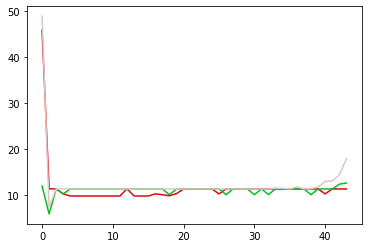

ROUND 43
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299421


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.247839
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322042
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325356
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.346835

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308336
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.332040
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.357376
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337432
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326171

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308250
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.326517
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.355633
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.292729
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297917
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308600
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.287329
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302546

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301118
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313697
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.324563
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.344394
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334602

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307780
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299109
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.371502
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.347508
Model client44 Train Epoch: 5 

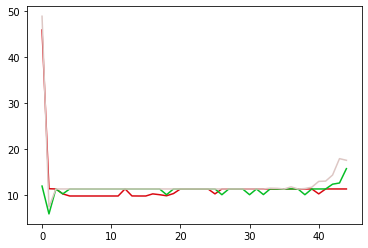

ROUND 44
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300752


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305682
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311579
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.358370
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.348337

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299791
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325778
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.361467
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.252723
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.352477

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301414
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.278432
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.365354
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.322948
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296778
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.320741
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.327674
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317418

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300775
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296242
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.359037
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.387846
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314575

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302048
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318388
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293083
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.369274
Model client44 Train Epoch: 5 

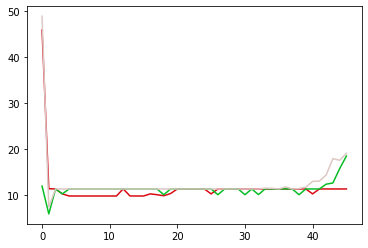

ROUND 45
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296153


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291508
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.337857
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.320768
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.279397

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308183
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291517
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.412786
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.335826
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326592

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302822
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327197
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.388686
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.264392
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318112
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308782
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.318155
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.298767

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307603
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334035
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.358306
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.318917
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.324593

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303582
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319347
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.375708
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.382221
Model client44 Train Epoch: 5 

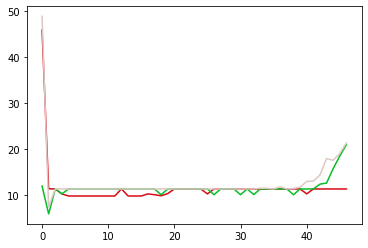

ROUND 46
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301200


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.265069
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.343994
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.352507
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291961

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301278
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.344735
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.320167
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.353559
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326507

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299481
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299801
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.336386
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.348157
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304765
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.276535
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.282660
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.294274

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303643
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.272558
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.248090
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.365098
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.331812

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305635
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.345570
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.376535
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.420966
Model client44 Train Epoch: 5 

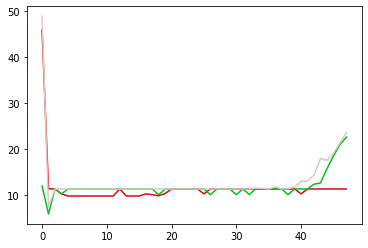

ROUND 47
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302882


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285192
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.205542
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.319557
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.333755

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297086
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.259045
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.351747
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.335518
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.340086

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296710
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310884
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.271329
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.350085
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.306012
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311928
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323781
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315305

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301451
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313211
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.334529
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323206
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.344832

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299997
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.341702
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.368551
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.348193
Model client44 Train Epoch: 5 

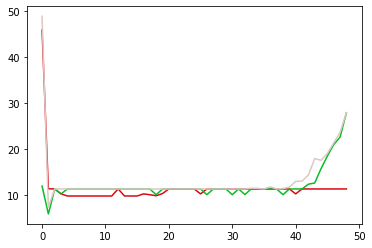

ROUND 48
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.277199


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305601
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.297495
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.371283
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.332990

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.259606
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.232064
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.294171
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.365076
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.174151

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.282435
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.329091
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.353118
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310951
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313583
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.243787
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317006
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302244

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.290362
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.259944
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302979
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.370476
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.321908

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304365
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.253974
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305837
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.370336
Model client44 Train Epoch: 5 

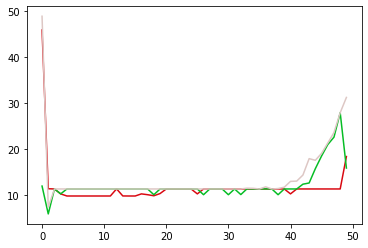

ROUND 49
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.138485


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323688
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.332238
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.380229
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.323665

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.185774
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.270880
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.218960
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.220294
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.247493

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.238463
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.353023
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339885
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.324532
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.207245
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306707
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.335395
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.318160

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.268759
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.218127
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323807
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.477828
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.967524

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.055796
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.252345
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.345666
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310078
Model client44 Train Epoch: 5 

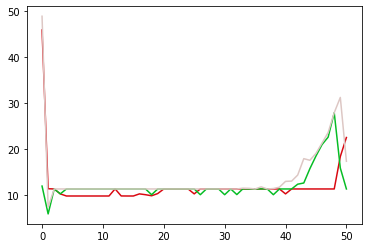

ROUND 50
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297427


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302031
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.388079
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.320452
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317973

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303608
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292330
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.994729
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.219553
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.259792

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300386
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328553
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.353183
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.289860
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289408
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.229380
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.216580
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.171571

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298165
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.247359
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.254691
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.269781
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304627

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297130
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300444
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.304710
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.285242
Model client44 Train Epoch: 5 

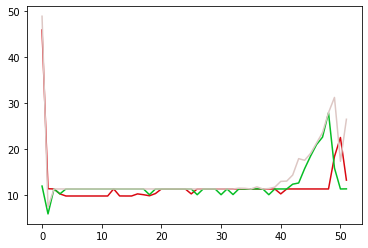

ROUND 51
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301992


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289637
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.284010
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.321717
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.441893

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296228
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.221962
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.271660
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.307223
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.255899

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.234829
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.264467
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.328357
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.373649
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.250127
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.232102
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.171314
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302320

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.287295
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.333048
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.340537
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.297563
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292861

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.282517
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.345222
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.309498
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.348185
Model client44 Train Epoch: 5 

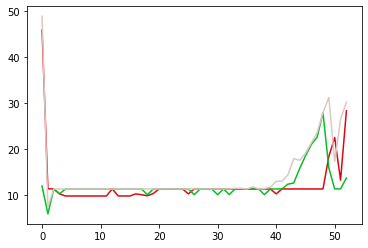

ROUND 52
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.266571


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.153256
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.224657
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.380647
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310711

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.265707
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.242278
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303077
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.331734
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314678

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.224807
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315904
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.329862
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.355083
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.164680
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.410563
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.265550
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.253596

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.230832
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.238823
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.354303
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.380010
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.419469

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.242094
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.016981
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.321772
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.256559
Model client44 Train Epoch: 5 

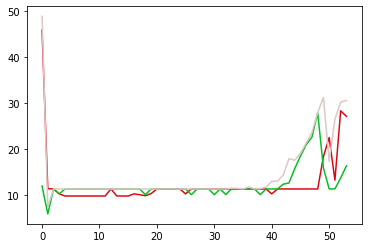

ROUND 53
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.190221


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299504
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.246818
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.450120
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.382743

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.269056
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.330375
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.370049
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.576663
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.368640

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.101639
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.114328
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.266482
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.243135
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286533
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.321083
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.225779
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.289582

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.219505
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.157650
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.256772
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.365179
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304442

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.143843
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.269395
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316605
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.468035
Model client44 Train Epoch: 5 

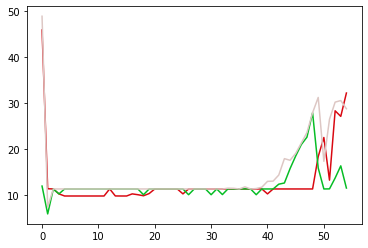

ROUND 54
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.195267


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296001
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.354932
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.390670
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.320862

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.253984
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.118422
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.284979
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.380373
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.337255

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.243079
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289859
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.213014
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.258839
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.284440
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.333331
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.319908
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.320030

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.246846
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.229585
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.255404
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.218631
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.305466

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291609
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.041219
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.200121
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.256461
Model client44 Train Epoch: 5 

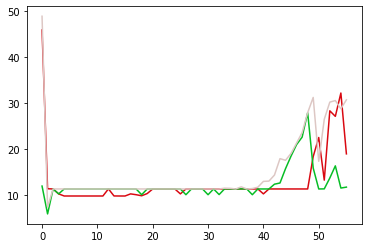

ROUND 55
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.192907


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305443
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.300832
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301966
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.365385

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.270707
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.192199
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.188568
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.198776
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.250468

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.155038
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.156185
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.151707
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.649471
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.220917
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.223985
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.302125
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.308069

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.240649
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.054302
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.422529
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.369978
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.323013

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.212935
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.351536
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.353290
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.368182
Model client44 Train Epoch: 5 

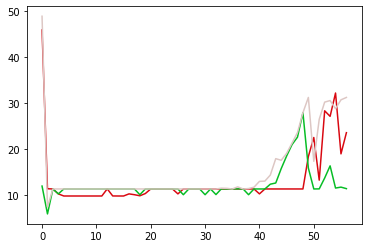

ROUND 56
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.125083


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.372242
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327044
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.356511
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.288949

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.211561
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.196967
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.356922
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330031
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.363893

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.078321
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.358330
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.397238
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.351625
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.198710
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.230306
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.291998
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.221607

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.220084
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.247213
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.390932
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.354120
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.276722

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.177609
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.251573
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.294039
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.372411
Model client44 Train Epoch: 5 

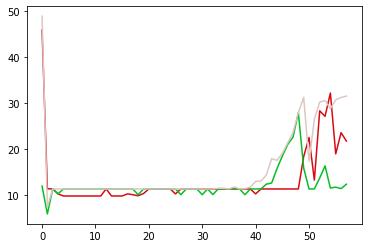

ROUND 57
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.212033


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323681
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.402870
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.353995
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.341783

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.265575
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320951
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.414540
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.444879
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.347497

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.178155
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.343915
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.380349
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.296148
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.239331
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291954
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.245374
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.342681

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.255425
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297492
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.289899
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.346470
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291561

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.213239
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292717
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.281618
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.287834
Model client44 Train Epoch: 5 

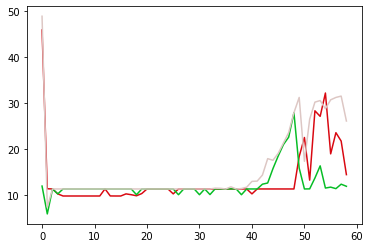

ROUND 58
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302562


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.195075
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 3.188900
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.356296
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303327

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.252291
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291250
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.410591
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.314399
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.394730

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.211167
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.194407
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.325987
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.360300
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293335
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323925
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.307311
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.290145

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.252406
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315787
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339693
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.368218
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297517

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299276
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.205065
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.260593
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.347081
Model client44 Train Epoch: 5 

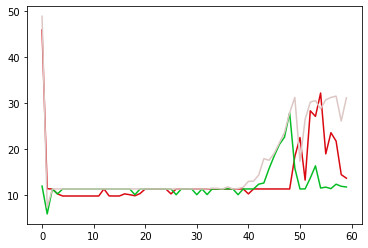

ROUND 59
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.182731


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305493
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.368050
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.483486
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.331278

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.121793
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288873
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308966
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.360465
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.350657

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.200548
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310682
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305644
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.391343
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301452
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327701
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.319192
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314385

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.220655
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.336547
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.347943
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.351032
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334888

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.230323
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.262111
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.381535
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.480848
Model client44 Train Epoch: 5 

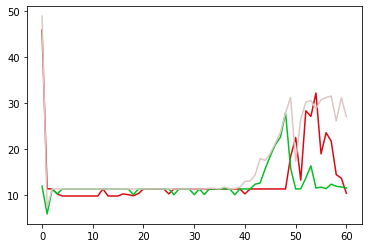

ROUND 60
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.190641


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.332994
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313202
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.333604
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314417

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.124237
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319577
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.358859
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.283057
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.348324

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.190510
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.183289
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.272187
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.334708
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.263705
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.309067
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.314462
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299518

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.262327
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.340358
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302326
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311830
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.296042

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.238205
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.231364
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.248712
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.379121
Model client44 Train Epoch: 5 

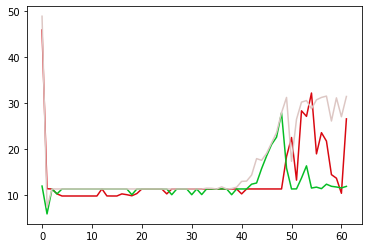

ROUND 61
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.164292


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313599
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.356572
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328476
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306980

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.203616
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318733
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.347492
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.286478
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.319293

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.141628
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.336842
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.389563
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.293740
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.065365
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.146212
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.209532
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292374

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.195753
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321638
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.340422
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.373850
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.289848

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.262948
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.259738
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.391659
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.402213
Model client44 Train Epoch: 5 

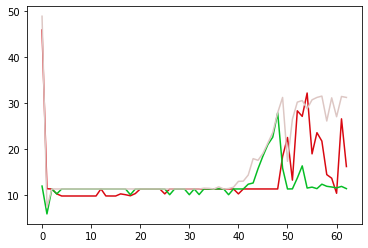

ROUND 62
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.203032


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.324530
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.343666
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.391653
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.347684

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.246010
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.366643
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.353814
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.320393
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.354411

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.175107
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.265238
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.369162
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.204787
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295857
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.319374
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310403
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.500345

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.226177
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.234167
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.295666
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328761
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.311330

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.230237
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.206199
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.368153
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.259370
Model client44 Train Epoch: 5 

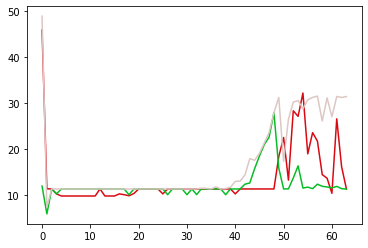

ROUND 63
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.225570


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322179
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.315655
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.356714
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.341462

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.274860
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.215041
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.388304
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.322341
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.386060

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.229804
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.284564
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.264043
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317533
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318269
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298311
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.292158
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.301311

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.239917
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.083503
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.309418
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.400539
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295180

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.247954
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.275793
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.402409
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.384617
Model client44 Train Epoch: 5 

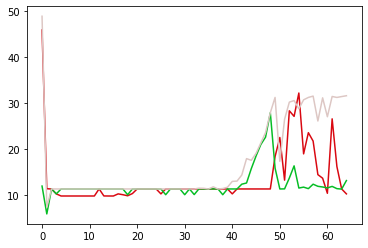

ROUND 64
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.237497


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286831
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.329737
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.370565
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.290368

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.146041
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310485
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327312
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.349890
Model client9 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.329504

Power Allocated= 0
CSI= 0.08232820773276639
SNR= 45.50891139395367
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 10.975826056716556
CSI= 0.9691247874926395
SNR= 29.206335

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315064
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.158876
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.238873
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304041

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.241280
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.235854
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.287371
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.381228
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297372

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.261266
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.150666
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.166771
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.332120
Model client44 Train Epoch: 5 

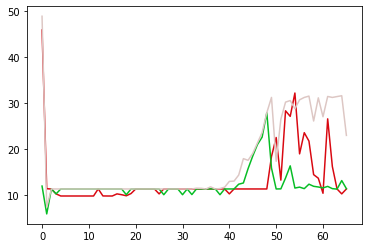

ROUND 65
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.068265


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309757
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317286
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.432325
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.329281

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309303
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.231830
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.355587
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.351180
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.362561

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.048099
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302146
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.435257
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323204
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.217870
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.167931
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.335955
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.312965

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.264754
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.239936
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.388901
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.382315
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.294018

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.132634
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.419840
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.286012
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.396973
Model client44 Train Epoch: 5 

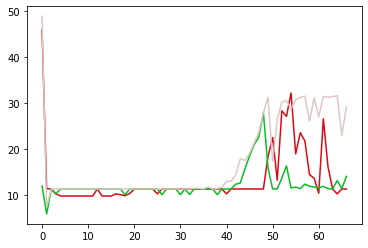

ROUND 66
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.257235


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289414
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.239809
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 7.684874
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326705

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.255894
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.240477
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.215989
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 3.344378
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.393101

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.251937
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.360145
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290850
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.380917
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.338843
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.352574
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317038
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303818

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.206530
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.115777
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330226
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.249151
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315110

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.223196
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.348242
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.285634
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.271948
Model client44 Train Epoch: 5 

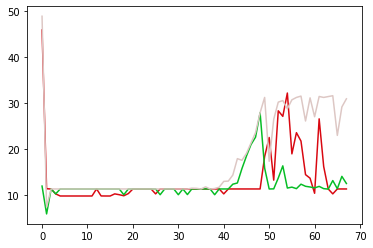

ROUND 67
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.192252


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328526
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.359075
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330895
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.358980

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.268976
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313811
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.444256
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.367743
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.283331

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.256405
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.365199
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.271034
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.443254
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309180
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.278043
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.285953
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303982

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.152185
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.068464
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.371186
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.406173
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.369578

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.269935
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317238
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378486
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 3.517239
Model client44 Train Epoch: 5 

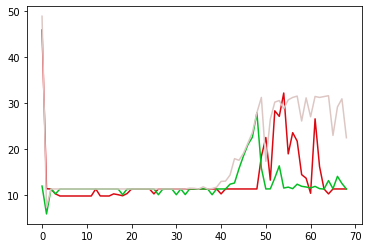

ROUND 68
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.248124


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301794
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.456125
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.465657
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334032

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.260381
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.343555
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.369770
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337212
Model client9 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.354438

Power Allocated= 0
CSI= 0.08232820773276639
SNR= 45.50891139395367
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 10.975826056716556
CSI= 0.9691247874926395
SNR= 29.206335

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323578
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312330
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.300594
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316267

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294143
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310237
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.385092
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.358660
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.324630

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.252211
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.342726
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.277495
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.375755
Model client44 Train Epoch: 5 

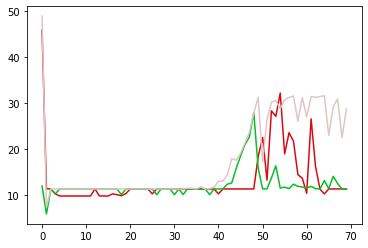

ROUND 69
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.118047


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.324281
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.468929
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.412474
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.382559

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.187036
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.219052
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.357418
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.327164
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.365308

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.218842
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.306663
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.387479
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.333586
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285003
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.304178
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.266560
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.341169

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.232354
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313015
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312354
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.416816
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.345342

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.225022
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.475403
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.483008
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.350160
Model client44 Train Epoch: 5 

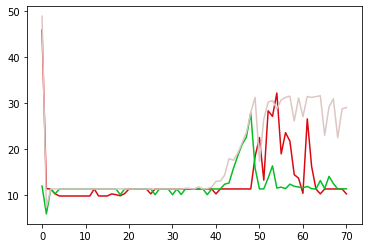

ROUND 70
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.244961


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320000
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.345034
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.443976
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.239191

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.220576
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.193049
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339005
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.357823
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.260007

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.163263
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292311
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.432961
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.251533
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305427
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313398
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.290787
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.321959

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.245954
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.274100
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.403076
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.376777
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306358

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.159146
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.133970
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.370763
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.435159
Model client44 Train Epoch: 5 

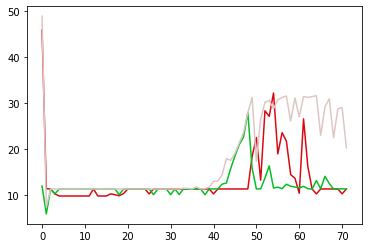

ROUND 71
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291415


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290586
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.276270
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.353473
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.305266

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.200948
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.326516
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.319993
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.332030
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.246536

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.205235
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310907
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.443342
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.389447
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315910
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.283210
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.272429
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306519

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291418
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.279660
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.186167
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.244550
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.227272

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.217782
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299260
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.368681
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.397780
Model client44 Train Epoch: 5 

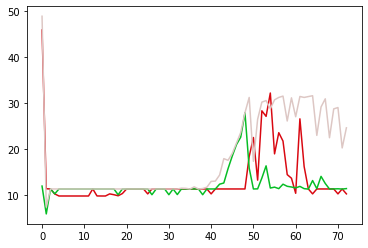

ROUND 72
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.282300


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.332059
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316658
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.420347
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.402579

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291947
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315305
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.372576
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.451054
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.371166

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.271210
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.394878
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.336553
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.315678
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316294
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.304818
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.298948
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306896

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.290386
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302834
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.307917
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.349096
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.325633

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303303
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334896
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327055
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.216569
Model client44 Train Epoch: 5 

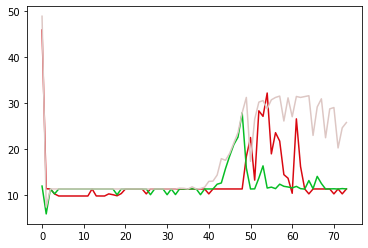

ROUND 73
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.133030


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.358049
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.439729
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.347612
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.332130

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.275580
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.306610
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.425973
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.372102
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.328464

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.143912
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323304
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.432680
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.362399
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.280947
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298424
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.273547
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.338055

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.259106
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295625
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.361084
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.380337
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.348739

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.249964
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.802158
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.354972
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.353551
Model client44 Train Epoch: 5 

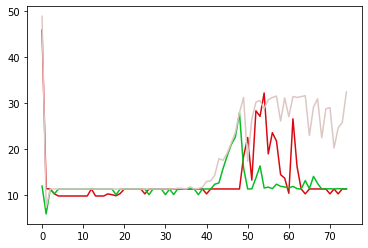

ROUND 74
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.232861


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.124240
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.341475
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.469246
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.330714

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.226746
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.226020
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.329443
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.345994
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.323157

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.228930
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286637
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.344517
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.365734
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297399
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.304473
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.339432
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313416

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.176418
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287401
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.372334
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.369884
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.372087

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.142462
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.142850
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.262471
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323147
Model client44 Train Epoch: 5 

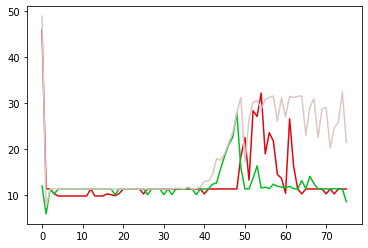

ROUND 75
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.218935


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319508
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.351646
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.425442
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.357137

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.254572
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313809
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.423357
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.386063
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.285507

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.233759
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.342712
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.319820
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.913294
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301178
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.237816
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.341841
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326135

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263906
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316420
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.360620
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.362752
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.377099

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.277546
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.258795
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.163477
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.354829
Model client44 Train Epoch: 5 

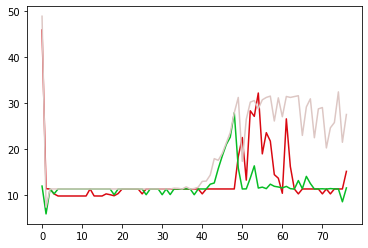

ROUND 76
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.240975


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.274400
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.411169
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.342112
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.312025

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.184160
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.366745
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311274
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.449055
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291094

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.177803
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319240
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.345402
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.348452
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287845
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.333711
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.291176
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.318475

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.247634
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307835
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.351205
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.348457
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.339335

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.248345
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.329180
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.250382
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.425322
Model client44 Train Epoch: 5 

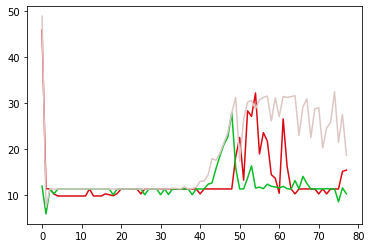

ROUND 77
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.218450


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313801
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.408436
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.236808
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.372319

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.218436
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.332485
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.478529
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.462344
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322474

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.257548
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287060
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.325580
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.344487
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292878
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339327
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.315618
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316580

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.264978
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319417
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.348698
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.336967
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.325323

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.225465
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.171032
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291083
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.371222
Model client44 Train Epoch: 5 

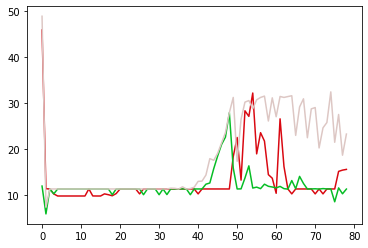

ROUND 78
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.205949


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.180069
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 3.008021
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 6.224496
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.290269

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.252910
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.340397
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.384318
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.338659
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.346429

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.232557
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.263572
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306368
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.398467
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311060
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323326
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.300779
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302900

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.223559
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.211308
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313324
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.352844
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.340115

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.146675
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.084393
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.228819
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.374340
Model client44 Train Epoch: 5 

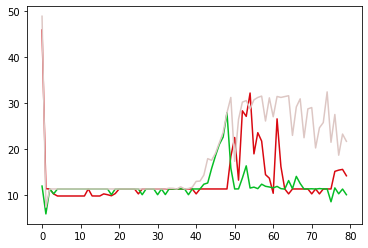

ROUND 79
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.248149


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.239152
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.413918
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.419333
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313174

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.210305
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.272197
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.394399
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.392987
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.352765

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.265393
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.399281
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.417791
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.388510
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295588
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.289645
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328233
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.298126

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.270443
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318040
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.391906
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.368124
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303766

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.166969
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310250
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.370507
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.343674
Model client44 Train Epoch: 5 

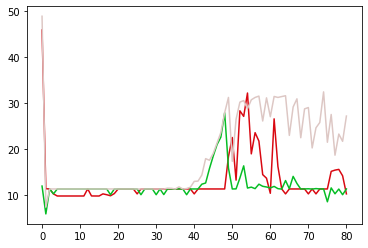

ROUND 80
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.181155


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.227876
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.418573
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.345595
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.382642

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.212775
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.262567
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.407833
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.377696
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.359697

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.209066
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.332947
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.354325
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.391254
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301932
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317334
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.290628
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297778

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.093359
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296043
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.344606
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.397227
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.274479

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.231203
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.364183
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.465481
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.378989
Model client44 Train Epoch: 5 

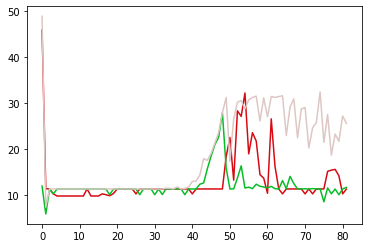

ROUND 81
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.265839


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.265122
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.343046
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.346525
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.344392

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293202
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285523
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.374355
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.376347
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315532

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.233605
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.326122
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.415864
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310104
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327054
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313617
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.320264
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.312370

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.235573
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315555
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.307290
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337082
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.344682

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.149819
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.356872
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322992
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.319270
Model client44 Train Epoch: 5 

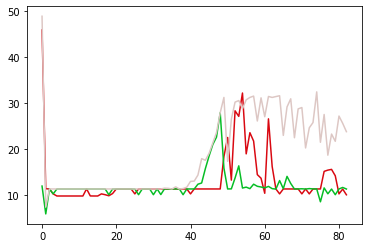

ROUND 82
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.202672


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.858544
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.348682
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.368634
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.357207

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.192314
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297140
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.350248
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.477921
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.340668

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.228624
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.330828
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.387623
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.397609
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310643
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.274611
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.282616
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.300510

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.208465
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303805
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298861
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.342031
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.350667

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.155724
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.341744
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.486665
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.350064
Model client44 Train Epoch: 5 

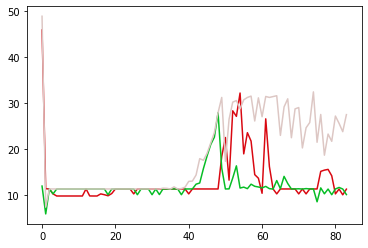

ROUND 83
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.272174


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.222854
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.469131
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.380825
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.280579

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300332
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.130380
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327149
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.360593
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334812

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.117931
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.350037
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.381351
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311527
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314223
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305111
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.292656
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.318433

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.081233
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.340452
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.336015
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.397410
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.319925

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.255708
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.331290
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.372216
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.318007
Model client44 Train Epoch: 5 

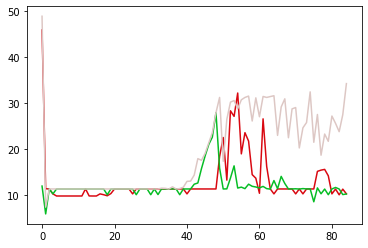

ROUND 84
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.181050


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.067822
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.374691
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.407706
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.350306

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.172005
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.138808
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.283333
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.401056
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.358846

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.206288
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.324155
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.366285
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.286489
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.106021
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313389
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.320857
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313782

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.234559
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.337751
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.401613
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310056
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303479

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.253562
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.333842
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.471537
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.422101
Model client44 Train Epoch: 5 

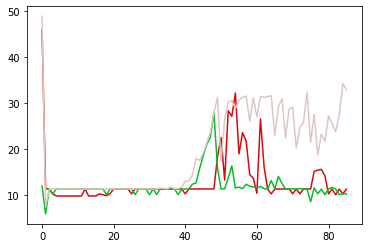

ROUND 85
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.094973


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.151992
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.367481
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.313937
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.442232

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.145125
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.257807
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.309276
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323027
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.312064

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.114285
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.357941
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.353800
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.349015
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.350063
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.324589
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.331924
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316666

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.252272
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.253544
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308439
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.398474
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.339118

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.092857
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.388861
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.278764
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.357126
Model client44 Train Epoch: 5 

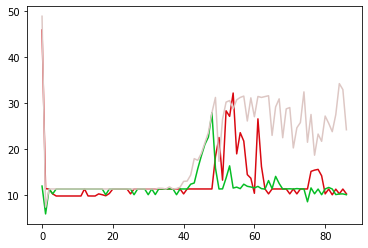

ROUND 86
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.273242


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.341847
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.282331
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.315372
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295107

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.109417
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.278284
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330263
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.452632
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.323699

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.169168
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.395178
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.391667
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.367448
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.251811
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306373
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317748
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310597

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.167494
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.257972
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.338351
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330585
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.281844

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.255823
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.357188
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.394111
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.340162
Model client44 Train Epoch: 5 

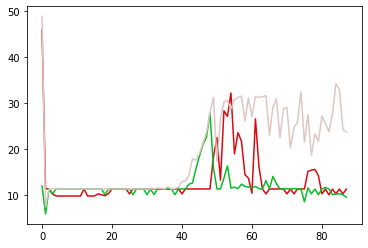

ROUND 87
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.187350


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.206662
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.347229
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.343856
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.372614

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.210759
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.249974
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.334109
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.293899
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.359765

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.194078
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286001
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.343795
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.361941
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.193197
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.375206
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.307791
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.275251

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.289092
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.245867
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.440207
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.417111
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.349336

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.199076
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.336945
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.453459
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.340683
Model client44 Train Epoch: 5 

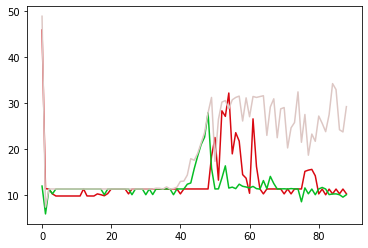

ROUND 88
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.149262


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.182279
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.357578
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.321274
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.307986

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.170452
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.171042
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.473701
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328262
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.341177

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.194166
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304785
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.410406
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.386233
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.134500
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.165383
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.332459
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.336733

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.096806
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289878
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.365426
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.280728
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.367657

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.017021
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312507
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.468060
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.347079
Model client44 Train Epoch: 5 

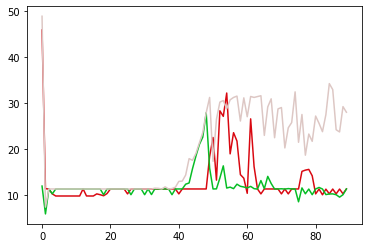

ROUND 89
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.080909


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310793
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339624
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.346652
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.376678

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.198977
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.339950
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339482
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.427038
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.374279

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.227278
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317328
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.422285
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.361384
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294064
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313454
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330470
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.281236

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.268243
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.284805
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.348558
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.378165
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.289972

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.237041
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322763
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.437570
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.302618
Model client44 Train Epoch: 5 

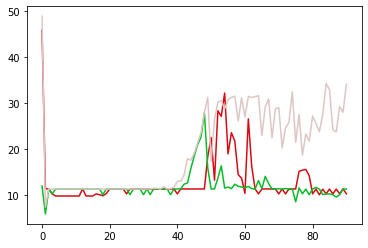

ROUND 90
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.211400


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.153079
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.382795
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337429
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.348361

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.192554
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.166641
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.264558
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.422181
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.444122

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.200858
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315355
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.335543
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308058
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.258690
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.179720
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.275268
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.332624

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.221596
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.178912
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.333824
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.339549
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291047

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.211253
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311551
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.301110
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.400858
Model client44 Train Epoch: 5 

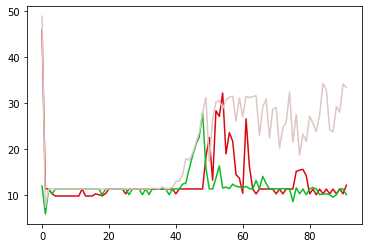

ROUND 91
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.101861


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.254388
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.297222
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.443680
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.366599

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.228531
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.220736
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.264314
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.426942
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.375896

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.110668
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290949
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.335164
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.474249
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.146280
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.315435
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.341668
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303007

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.091574
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.201065
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.268230
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.391899
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334517

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.089815
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312653
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.375991
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.390671
Model client44 Train Epoch: 5 

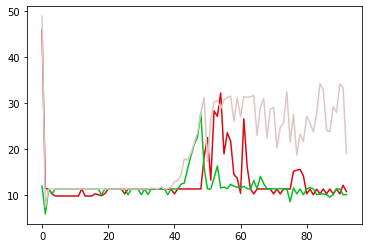

ROUND 92
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263207


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.092859
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.254683
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.439854
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317110

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.267192
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304736
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.367113
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301510
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.328626

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.225155
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.350986
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339531
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.292309
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301312
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.340411
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.281323
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315486

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.160344
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285305
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.416665
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.362059
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.341470

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.238984
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.344262
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.349519
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325673
Model client44 Train Epoch: 5 

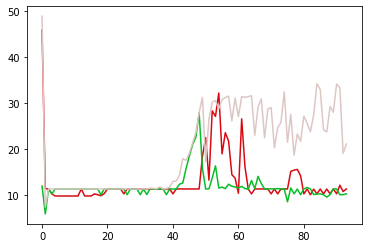

ROUND 93
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.243279


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304351
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.427135
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.450990
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.309395

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.270627
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316354
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.377461
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.480177
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292001

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.225461
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320429
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.333516
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.358434
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293505
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.309980
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311974
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326140

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.266357
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.277215
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.405991
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.390211
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.320515

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.204051
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321704
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.507194
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.431795
Model client44 Train Epoch: 5 

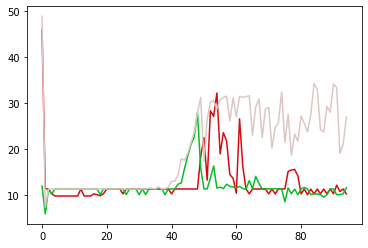

ROUND 94
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.053979


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319704
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.384464
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.447644
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.361468

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.275444
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.284630
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.360795
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.436382
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.276781

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299053
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.232420
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.348675
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.362882
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290288
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.288275
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.348958
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304560

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.228600
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.272138
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.769813
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.523076
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.361526

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.195137
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.345889
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.422682
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.304212
Model client44 Train Epoch: 5 

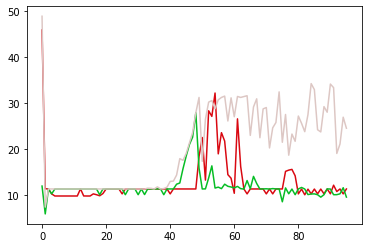

ROUND 95
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.212941


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.348458
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.347200
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.340796
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.371423

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.160660
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.339396
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.333118
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.440926
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.328773

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.227453
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.246989
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317288
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.342025
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309177
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.341841
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.318730
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.283829

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.328051
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.324138
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.320715
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.380983
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.279480

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.187139
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.337802
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.388016
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.322163
Model client44 Train Epoch: 5 

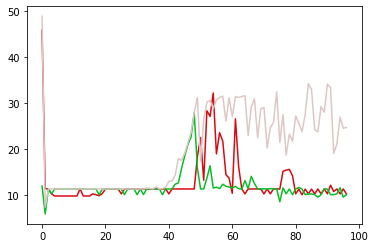

ROUND 96
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.195543


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298133
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.422415
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311792
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.311717

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.190378
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.267171
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378136
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.302438
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.413272

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.226076
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322307
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299644
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.381908
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294490
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302747
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.302368
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.283776

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.171072
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.271282
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.304007
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.358729
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.343112

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.183588
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314379
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.409250
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.331813
Model client44 Train Epoch: 5 

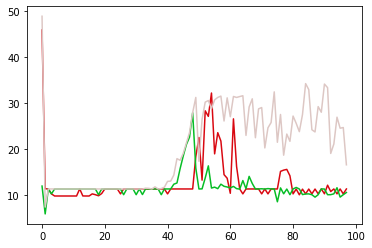

ROUND 97
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299467


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.244269
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.400257
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.394452
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.319904

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.288997
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293050
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.441419
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.373811
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.377958

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.266052
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307590
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.335030
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.349693
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303878
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.340545
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.363660
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.325895

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.238307
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.329344
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.360862
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329426
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.409638

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.222212
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303479
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.354588
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.478288
Model client44 Train Epoch: 5 

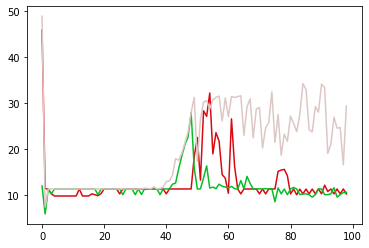

ROUND 98
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.237031


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.262243
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.368173
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.314011
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.352118

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.203649
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308290
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.443418
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.333266
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.379658

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.153010
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.347904
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.372343
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.371372
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285979
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.283785
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329340
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.305407

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.144432
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.341208
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.384119
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.404980
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.338052

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.289584
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.375166
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.329918
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.431700
Model client44 Train Epoch: 5 

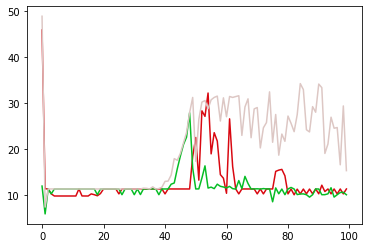

ROUND 99
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291730


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294772
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.410999
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.361126
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.346885

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296392
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.332949
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.369289
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.518377
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.328481

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.220420
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316919
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.370576
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.262830
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.350894
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.344504
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.342528
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314723

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.276586
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.353372
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.361120
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.371786
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.379044

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.251579
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.374055
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.424893
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.336532
Model client44 Train Epoch: 5 

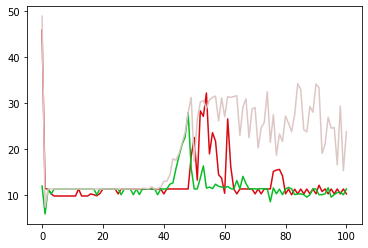

ROUND 100
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.226434


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.157490
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330394
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.400146
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.354013

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.266502
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.553582
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.266657
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.493097
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.387248

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.280335
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325064
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290823
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.303465
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293413
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.319293
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.340681
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304359

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306900
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295012
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.353678
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.377305
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.382758

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.240308
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.171958
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.338632
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.417784
Model client44 Train Epoch: 5 

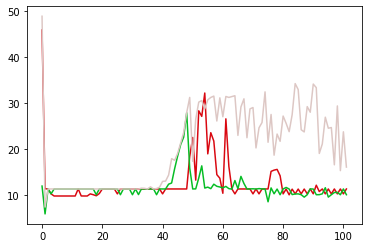

ROUND 101
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300707


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.143712
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.349215
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.416812
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.386482

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.266397
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.217089
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330793
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.483227
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.362438

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296663
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.324635
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.439904
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.398302
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302190
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317123
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.290558
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.340876

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.237281
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.365442
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.333810
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.343561
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.265132

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.157788
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.337865
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.448135
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.431726
Model client44 Train Epoch: 5 

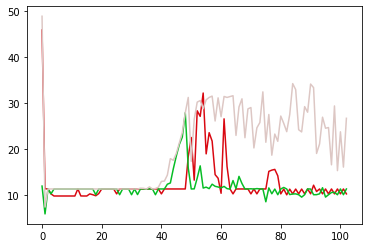

ROUND 102
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.065506


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.382288
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.373048
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.439363
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310674

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.197171
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293239
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.389404
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.468239
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.377689

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.160487
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.348555
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339151
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.390104
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.272177
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.340778
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.331303
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304706

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263806
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.350467
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.395780
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.353474
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.352132

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.269094
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.233872
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.462385
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.553124
Model client44 Train Epoch: 5 

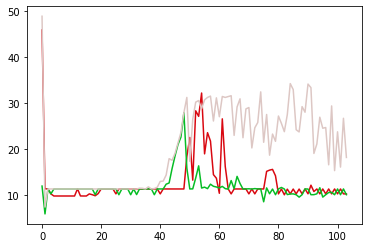

ROUND 103
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301327


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.070700
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.393442
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.420690
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.340465

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.266648
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.281662
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296843
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.440869
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.388490

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.192001
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322114
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.433188
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.375007
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.227483
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302969
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.305256
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.341048

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.287082
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.339227
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.337838
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.346376
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.360551

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.169315
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.348185
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.507540
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.496169
Model client44 Train Epoch: 5 

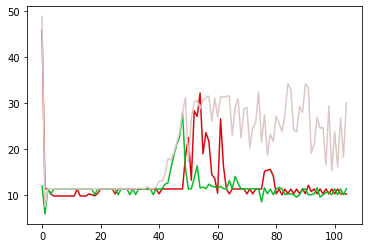

ROUND 104
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.216151


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303913
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.473716
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.334473
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.321961

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.138274
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.271627
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.364688
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.467560
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299283

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.266448
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.330481
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314954
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337145
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296529
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.341447
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.332023
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.312268

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.101445
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308104
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.367846
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.341528
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.285123

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.193673
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.253579
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.449851
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.429224
Model client44 Train Epoch: 5 

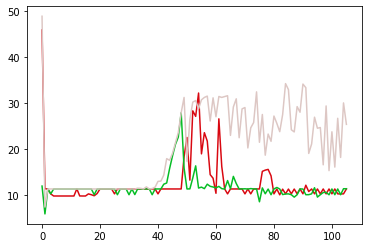

ROUND 105
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.253671


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317417
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.376088
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.380571
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.351416

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.271071
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.374128
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.335336
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.473753
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.380788

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.254247
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.351635
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.358864
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310436
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.277755
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330950
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.340609
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304463

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301779
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.366864
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.331735
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.357500
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.333876

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.267887
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.339710
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.385118
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.457942
Model client44 Train Epoch: 5 

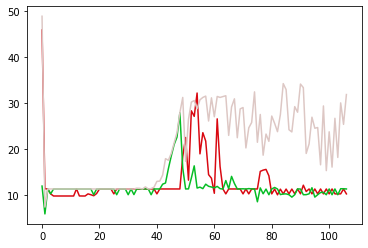

ROUND 106
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.081450


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314599
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.377597
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.423890
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.330819

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.126269
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.385826
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.414792
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.403419
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297049

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.080252
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319798
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.347501
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.264569
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.205932
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.309365
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.343472
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.301492

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.355759
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.340309
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.446593
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.468271
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.333098

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.121747
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.275124
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.261158
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.400870
Model client44 Train Epoch: 5 

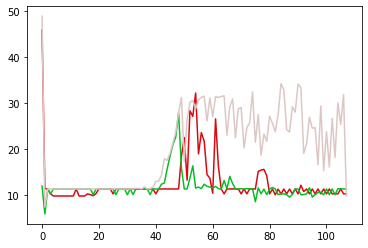

ROUND 107
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298845


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.342631
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.410423
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.458300
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291559

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303026
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304711
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312917
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.426648
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.318315

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304844
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.283411
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.344858
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.361439
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299182
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.337603
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.379117
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322460

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303782
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298900
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.394387
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.294515
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306253

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301630
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.339983
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.373774
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.466812
Model client44 Train Epoch: 5 

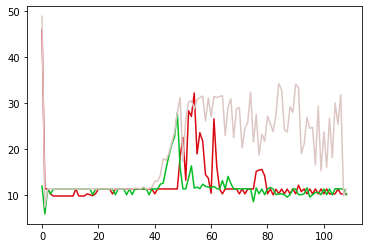

ROUND 108
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303306


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313250
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290616
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.420874
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.330113

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301852
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.351748
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.419649
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.486125
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.284367

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306428
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302018
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327334
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.359149
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290664
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.309722
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.304708
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.329006

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305395
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309600
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.380619
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.326732
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.331206

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303289
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.330097
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.346710
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.423776
Model client44 Train Epoch: 5 

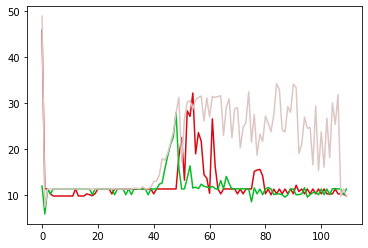

ROUND 109
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300844


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300514
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.362081
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.354791
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.347158

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303965
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.337882
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.413233
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.399634
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.353199

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300346
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.270456
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314723
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325748
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318395
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.365971
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.364730
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322273

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307068
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.346927
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.337919
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.425956
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.349057

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300453
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.354867
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.392002
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.364062
Model client44 Train Epoch: 5 

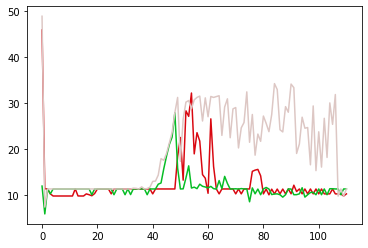

ROUND 110
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301044


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.344913
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.374084
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323331
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.340698

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303845
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.353760
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.403738
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.336119
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.332123

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297728
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.284471
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.283465
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.420090
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.335647
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311368
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.344524
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.293166

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306277
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303870
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.395065
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.353689
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.319128

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305613
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320190
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.403136
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.396896
Model client44 Train Epoch: 5 

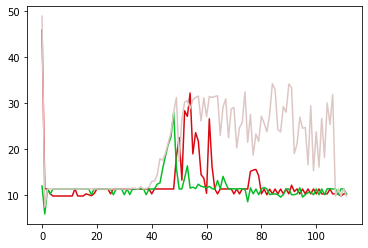

ROUND 111
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299675


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.340538
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.371354
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.343956
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.362756

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299179
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.365412
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.436950
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.373785
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.346522

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302755
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309832
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.375803
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.373202
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.333370
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.343654
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.305210
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.318876

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303671
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.338908
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.271752
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.425538
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.333875

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299384
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309432
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.353179
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311281
Model client44 Train Epoch: 5 

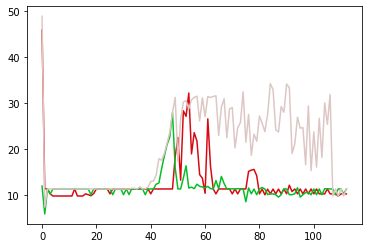

ROUND 112
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297548


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320373
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.336876
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.326305
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295660

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304792
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.363746
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.419990
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.392444
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.374482

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295566
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.332281
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.355713
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.417955
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301169
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.345936
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.275390
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306698

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300496
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.350865
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.421484
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.342432
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322399

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307026
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.344784
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.437767
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.418417
Model client44 Train Epoch: 5 

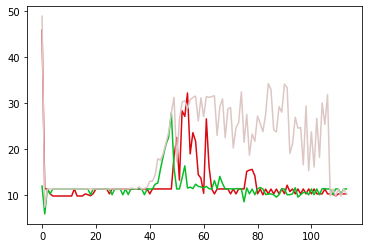

ROUND 113
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304900


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.339159
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.281622
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.398883
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.250649

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308729
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328166
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.392202
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.372950
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.369167

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300982
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300195
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.385876
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.360250
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309650
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.331748
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329276
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317105

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301219
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328789
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.354953
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.397886
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317118

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305605
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.337955
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.443164
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.294287
Model client44 Train Epoch: 5 

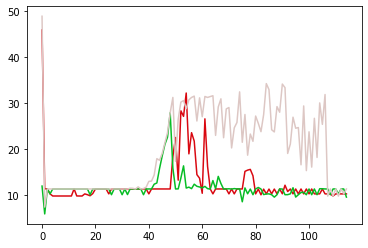

ROUND 114
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303801


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323494
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.362558
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.376580
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.374966

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305230
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.411335
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.346736
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.471982
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.353247

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304510
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315171
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.332382
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.246293
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301564
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.310791
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.369755
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.287868

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301160
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.283421
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.453087
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.345311
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.289708

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298056
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289954
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.412590
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.419436
Model client44 Train Epoch: 5 

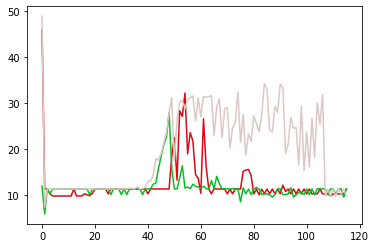

ROUND 115
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302794


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.324642
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312073
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.459538
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.301049

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304435
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307576
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.341292
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.359020
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.311222

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303710
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322264
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339746
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.484209
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314384
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.334540
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.332795
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304300

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299766
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316440
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.397822
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.261035
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.365382

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299285
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.380973
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.444267
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328538
Model client44 Train Epoch: 5 

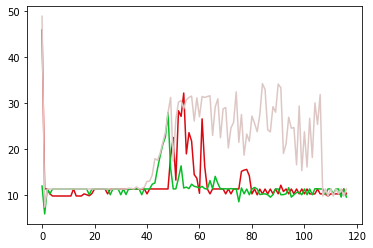

ROUND 116
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298349


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318423
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339073
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.376838
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302558

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303116
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327094
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.365834
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.352162
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.274148

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298390
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.266035
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378026
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.398161
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294413
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339331
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.286601
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292217

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300412
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.280457
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.370900
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.364595
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.331884

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302989
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.279082
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.360893
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.424253
Model client44 Train Epoch: 5 

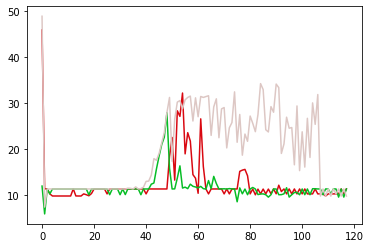

ROUND 117
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302387


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.337155
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.370873
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.363395
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.352008

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299079
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328463
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314708
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.368724
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.309455

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300991
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.390536
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290022
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.302544
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.336664
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311110
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.342165
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316664

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302947
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313358
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.387865
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.373789
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.352100

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304939
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.277969
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.271193
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.314956
Model client44 Train Epoch: 5 

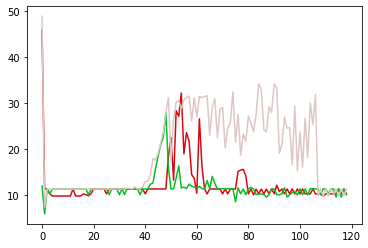

ROUND 118
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302979


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299706
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.356412
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.376867
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.324752

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300858
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334709
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326002
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.387129
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.277435

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297846
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.348257
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.415279
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337963
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312404
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299034
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.305243
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304682

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303704
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300841
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.266163
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.350945
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.354835

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300782
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300639
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.398574
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.335722
Model client44 Train Epoch: 5 

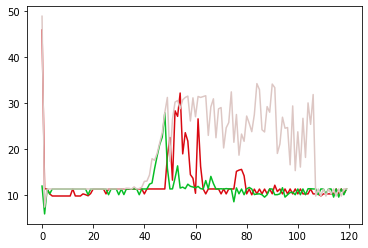

ROUND 119
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294670


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289761
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.414559
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.359114
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.357248

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303752
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.358397
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.405244
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.307126
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334337

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303393
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313092
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.418721
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.380342
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.329636
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.354002
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.315368
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297311

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301658
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323910
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.353698
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.412007
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.328247

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306563
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304023
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.355566
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.488397
Model client44 Train Epoch: 5 

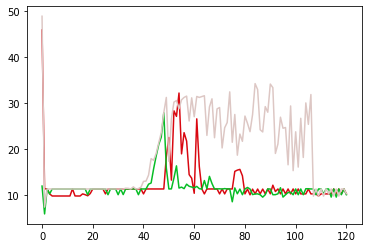

ROUND 120
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303505


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307168
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.363224
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.363718
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.300586

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301520
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289858
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.397285
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.389737
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.336133

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302904
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.282651
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.337170
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.424942
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286098
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.346170
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.276953
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313184

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301088
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308335
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.371140
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.380545
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.343065

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302821
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304466
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.434683
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312231
Model client44 Train Epoch: 5 

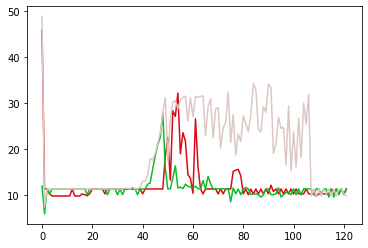

ROUND 121
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298880


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.350112
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.346357
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.399268
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.366834

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300781
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321711
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.386443
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.424942
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.392008

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300602
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.355283
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.328113
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.455122
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296048
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.282583
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.315320
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317133

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300140
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290789
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.336779
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.320363
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.346408

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304017
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312511
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.420012
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.405353
Model client44 Train Epoch: 5 

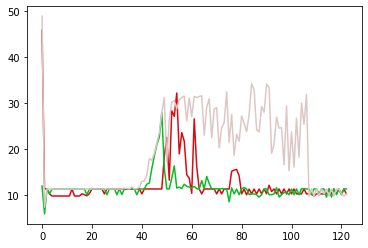

ROUND 122
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299914


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288867
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.344280
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325152
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.325496

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303097
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.391841
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.417439
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.280863
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.377587

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300689
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322447
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.406095
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.394213
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314154
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.346403
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337772
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303803

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301030
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301027
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.401199
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.272448
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.379689

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303230
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.271169
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.376534
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.476480
Model client44 Train Epoch: 5 

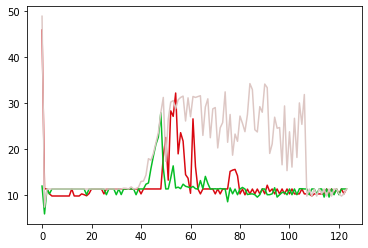

ROUND 123
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301276


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308929
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.343676
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.290777
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.356215

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302501
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295968
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.388269
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.385465
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326443

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302305
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.370431
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327219
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.359230
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314325
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323431
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.322886
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.277872

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303382
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304195
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.334428
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.332749
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.343369

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300662
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310751
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.359218
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.404258
Model client44 Train Epoch: 5 

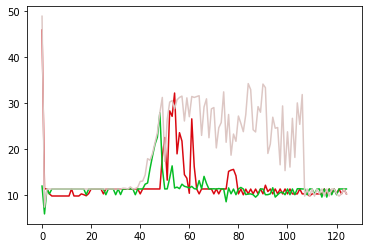

ROUND 124
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300565


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297220
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.355742
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.342288
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.343875

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302432
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299565
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378039
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.357352
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295967

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298560
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288621
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.463273
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311600
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294514
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305912
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.349367
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317278

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303622
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328829
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.402289
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330248
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.362137

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301691
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295277
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339749
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.398604
Model client44 Train Epoch: 5 

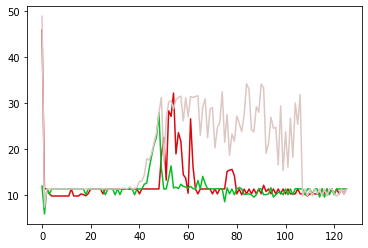

ROUND 125
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297937


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299501
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318227
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.419476
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.352208

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306277
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314772
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.390501
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.374465
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.370214

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304724
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.398029
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322148
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.357025
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.306513
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316427
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.335744
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.301219

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301885
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320090
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308940
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.347983
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.387374

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302969
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.284062
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.366085
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.286077
Model client44 Train Epoch: 5 

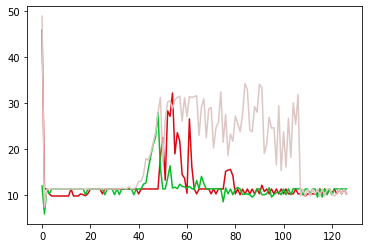

ROUND 126
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299209


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323547
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.342455
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.309174
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.308153

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304287
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.373930
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306379
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.366656
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.340086

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297045
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315248
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.396406
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.371479
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309935
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314772
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.314281
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304254

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302276
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.279848
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298677
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.385290
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.270101

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299744
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.266146
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.411054
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.475241
Model client44 Train Epoch: 5 

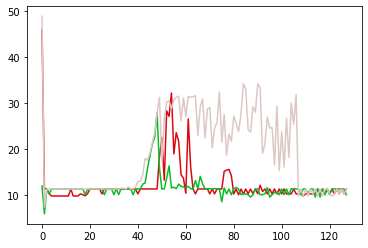

ROUND 127
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300354


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.283701
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.381337
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.411048
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.281034

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299700
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.352703
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.393651
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.418458
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.367133

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302699
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312034
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.419303
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.367329
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297411
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311547
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337028
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.307303

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300810
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.270954
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.332784
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.303154
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.339198

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306317
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.009202
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.257329
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.395904
Model client44 Train Epoch: 5 

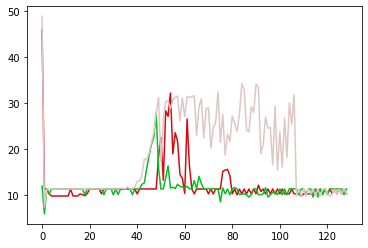

ROUND 128
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300145


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294410
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.399038
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.381608
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.343812

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302990
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.346652
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.370330
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.385322
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.323980

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300835
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321795
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.412882
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.388036
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295614
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.307871
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.300095
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.300936

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301267
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.278916
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.365584
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.391250
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.290104

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301748
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308941
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313118
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.321548
Model client44 Train Epoch: 5 

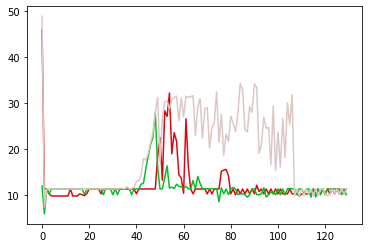

ROUND 129
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306085


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292380
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.398692
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.352596
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.339292

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301599
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327549
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.349200
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.295955
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310671

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300521
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.341976
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.391234
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.327611
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313844
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322101
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.332511
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.267277

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305856
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.343065
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.425103
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312480
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.349128

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302492
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.340475
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.407376
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.391880
Model client44 Train Epoch: 5 

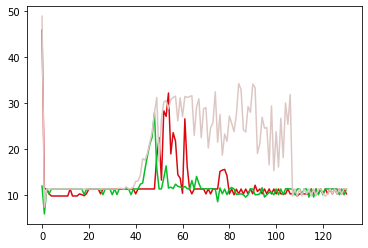

ROUND 130
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301644


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334745
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.354416
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.371025
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295703

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300493
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.366088
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.514882
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.405336
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.330756

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298113
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.337500
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.289541
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.350379
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307058
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.226350
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.296606
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304973

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299416
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.336291
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.344259
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.341222
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.266834

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303285
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.355757
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.477625
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.458661
Model client44 Train Epoch: 5 

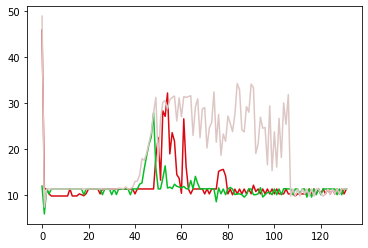

ROUND 131
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303648


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.336547
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.407568
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.469211
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.338670

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300497
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.344818
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.332169
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.367404
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.305052

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304343
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305420
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.411907
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.477701
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297588
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312095
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337878
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.275216

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300546
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.342491
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.346012
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.372977
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.331272

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298082
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311700
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.321762
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.401283
Model client44 Train Epoch: 5 

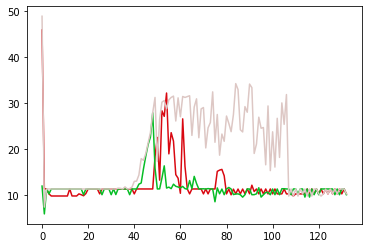

ROUND 132
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304500


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.336283
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.321099
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.324676
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.400522

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306649
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.381371
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.436945
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.319866
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.380435

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304389
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.376584
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.368901
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329877
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.326514
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.288728
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.322091
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297395

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305544
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303480
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.307539
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325751
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.275312

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304635
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334042
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.351587
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.445172
Model client44 Train Epoch: 5 

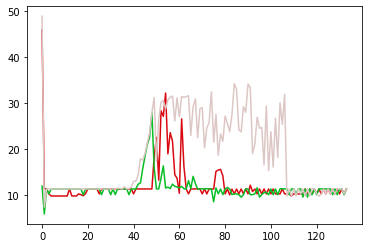

ROUND 133
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296897


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.340673
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.362085
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.386640
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.308098

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306729
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322592
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.384110
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.464677
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.333984

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299710
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.276182
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.289336
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.367542
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311023
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296776
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308477
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302160

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302145
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328392
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.383810
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.349196
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.350744

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298362
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312684
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.389063
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.353051
Model client44 Train Epoch: 5 

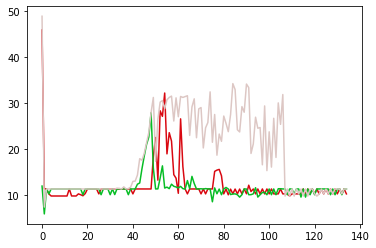

ROUND 134
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302451


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298808
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.389808
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.371919
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.279015

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302106
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.282201
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.407446
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.443742
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.320826

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301221
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307376
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.331335
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.420187
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296016
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.253226
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.333145
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.287753

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303415
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.272494
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316861
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.327016
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334802

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301548
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305210
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.428004
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.414676
Model client44 Train Epoch: 5 

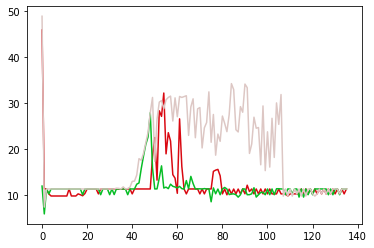

ROUND 135
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303322


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328649
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.277659
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.395739
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.309620

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301109
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316743
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.276668
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.361028
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295767

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301535
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322333
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.319587
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.344339
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.324792
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.354719
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.342071
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.293191

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301704
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.336526
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.336727
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330924
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.282722

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303930
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.335146
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.344434
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.409271
Model client44 Train Epoch: 5 

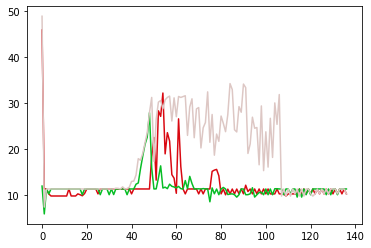

ROUND 136
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299781


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.280104
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.358702
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.358238
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315737

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302894
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328014
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.387196
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.431932
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.329906

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301060
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308097
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.364810
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.406635
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320621
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316433
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.283539
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.324878

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305754
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328478
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.419614
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.373204
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.246114

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307726
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.358167
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.426312
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.368876
Model client44 Train Epoch: 5 

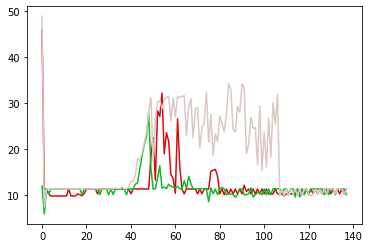

ROUND 137
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304719


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334534
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378626
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.367227
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.308084

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305771
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.332717
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.446039
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.357673
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334908

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302665
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.275835
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.405974
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.357989
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315165
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.337251
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.296468
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317252

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304896
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328269
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302293
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.354413
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.289559

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308685
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291919
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327055
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.352234
Model client44 Train Epoch: 5 

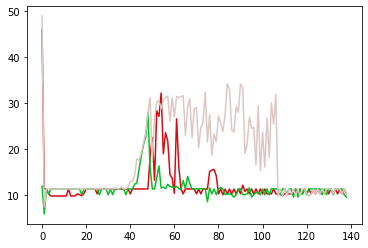

ROUND 138
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303153


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289260
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.375331
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.304917
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.350788

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306375
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.358480
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.307349
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.430552
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.360309

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302343
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.345959
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.390863
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.396956
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313250
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.297396
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312401
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317826

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302132
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.276281
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.284314
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.261323
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315119

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305097
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.344470
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.404971
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.415759
Model client44 Train Epoch: 5 

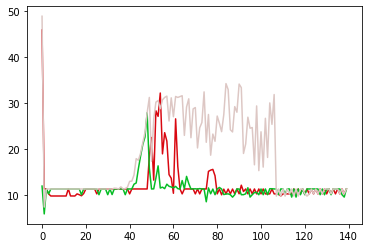

ROUND 139
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298555


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.279607
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.238536
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.349087
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.366367

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298473
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.354146
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.377644
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.374046
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.337470

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307553
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309450
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299257
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.360425
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.274158
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.341023
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.352024
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304302

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297498
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.337353
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.369859
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.388348
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.307927

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296307
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.380354
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318396
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.358911
Model client44 Train Epoch: 5 

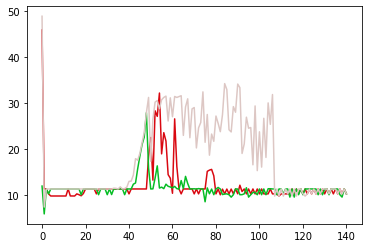

ROUND 140
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298728


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.284388
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323912
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.298129
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.331840

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304692
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317795
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.443190
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.373049
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314982

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303352
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.333327
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.400578
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.445079
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.324451
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305222
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330185
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.301582

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Poor Channel, client not taken for averaging in this round

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300431
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334445
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.382906
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.406856
Model client44 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.378967

Power Allocated= 10.597324054098017
CSI= 0.7090383924773043
SNR= 29.578820033989516
Client: client46
Model client46 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305220
Model client46 Train Epoch: 2 [0/1216 (0%)]	Lo

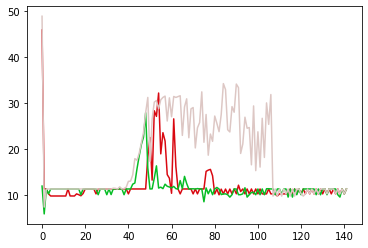

ROUND 141
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302070


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.371069
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.281879
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.322561
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.339478

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305910
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.377295
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.411619
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.378147
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.288415

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304476
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287189
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.382242
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.419566
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325306
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.274571
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.272494
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316289

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299170
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.336214
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.488978
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.372873
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.294822

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297481
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.354056
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378739
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.388414
Model client44 Train Epoch: 5 

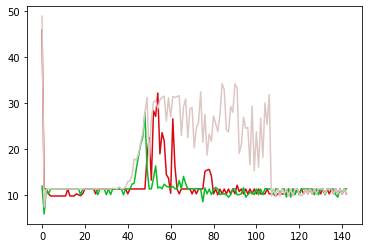

ROUND 142
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304123


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.343442
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.355494
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.362092
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.355156

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300029
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299764
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.405339
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.423054
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313191

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304611
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319788
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.434798
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.370637
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315187
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339417
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.295515
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.329919

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298503
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313330
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.377553
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.360149
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315009

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302213
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308109
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.361195
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.411501
Model client44 Train Epoch: 5 

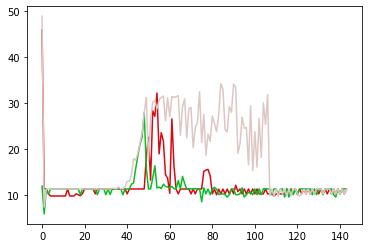

ROUND 143
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300252


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304601
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.393264
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.339131
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.354218

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300168
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.340008
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.341645
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.366457
Model client9 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.287345

Power Allocated= 0
CSI= 0.08232820773276639
SNR= 45.50891139395367
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 10.975826056716556
CSI= 0.9691247874926395
SNR= 29.206335

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.326723
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330492
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.303496
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.330710

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299346
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.335732
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.392298
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.404373
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.354106

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302531
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.337245
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.399558
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.431034
Model client44 Train Epoch: 5 

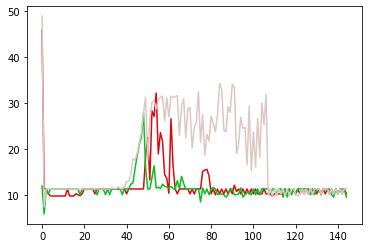

ROUND 144
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301078


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289656
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.368984
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.425603
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.361938

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302678
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325870
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.233414
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.352006
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.277486

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298439
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328651
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378158
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.384635
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.306467
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.320341
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.294433
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334285

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304239
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.374982
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314006
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.383982
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310715

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304707
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.369216
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.399859
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.388062
Model client44 Train Epoch: 5 

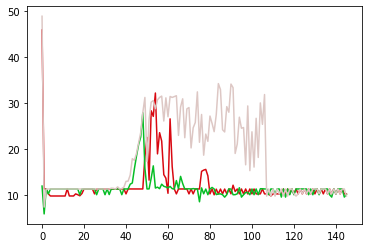

ROUND 145
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301051


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.352749
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.420528
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.333144
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.350016

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301884
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318357
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.411925
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.379592
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.300797

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300502
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287549
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.395105
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.381125
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317281
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293888
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329263
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.308268

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295712
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307037
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.400834
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.444373
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.329319

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303117
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318551
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.344007
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.416488
Model client44 Train Epoch: 5 

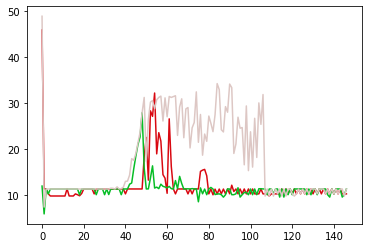

ROUND 146
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308122


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.261942
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.352041
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.398976
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304410

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306527
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.326284
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.361638
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.275059
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.271357

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298844
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300247
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.347156
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.321122
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.330989
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313609
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301516
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299904

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301039
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316859
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.383405
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.324428
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.362250

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302933
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.341958
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.465379
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.353590
Model client44 Train Epoch: 5 

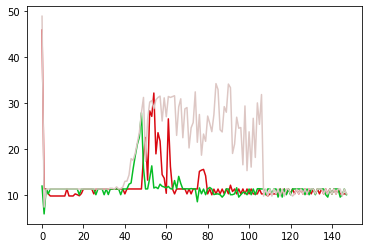

ROUND 147
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306809


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.269001
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.449606
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.465241
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.361678

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298029
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322358
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.355031
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.306936
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.388756

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300663
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298565
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313514
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.357276
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301438
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.333243
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.295229
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299345

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299387
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334263
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.387955
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.404869
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.341512

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304378
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.344313
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.445484
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.347114
Model client44 Train Epoch: 5 

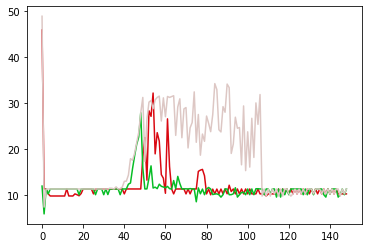

ROUND 148
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296315


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323571
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.437729
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.369259
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.393854

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303272
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318618
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.440211
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.375508
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.352537

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300911
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.370802
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.321527
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328564
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288386
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.355625
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317399
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.288280

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299165
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.399443
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305645
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.331685
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302243

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301494
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.360524
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.344367
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.423532
Model client44 Train Epoch: 5 

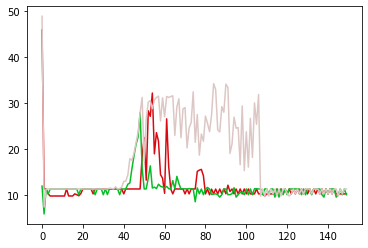

ROUND 149
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300266


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.343256
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.236897
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.407242
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316744

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307062
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303932
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.385567
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.478353
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.385988

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301503
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312948
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.346449
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.389786
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304454
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.309474
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.327911
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.298763

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299596
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320587
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.381250
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328251
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306838

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300061
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290151
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.370966
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.468328
Model client44 Train Epoch: 5 

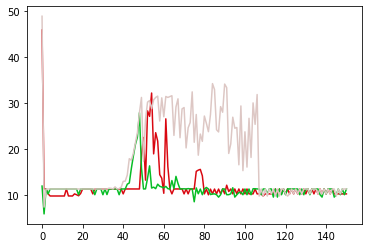

ROUND 150
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297506


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.329994
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.430767
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.382552
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.344172

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305097
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318022
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.321283
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.369482
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.329608

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303865
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307210
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.295910
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.339972
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307445
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.371322
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.333017
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313605

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300045
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292979
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.498955
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.397977
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.343506

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306576
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321750
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296066
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.427631
Model client44 Train Epoch: 5 

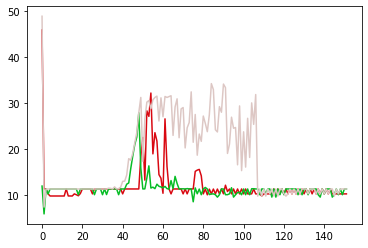

ROUND 151
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304361


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.182127
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.417772
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.346531
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.331764

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300563
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327697
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.360007
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.363317
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.350273

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302949
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319493
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.369394
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.350782
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311553
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.344450
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.343340
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317372

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301107
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.347813
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.301135
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.393276
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.341013

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301010
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323749
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.262903
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.472917
Model client44 Train Epoch: 5 

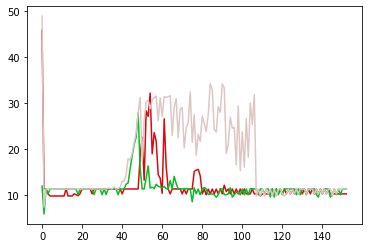

ROUND 152
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306205


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.381773
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.350849
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.412506
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.390086

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304472
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305834
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.397959
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.407941
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313963

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303664
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301142
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.320909
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.343895
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.330422
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.288774
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.295529
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.275266

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303272
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327930
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330817
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.450100
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302614

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300745
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.359921
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.390824
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.379594
Model client44 Train Epoch: 5 

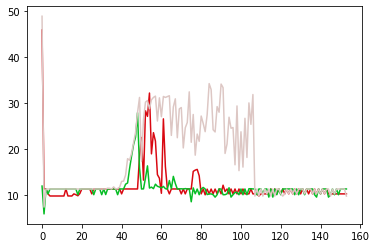

ROUND 153
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301888


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.280397
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.267781
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330771
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.380707

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305473
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.330904
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.336627
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.371850
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.398437

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296951
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286552
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.350598
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.339368
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307845
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303351
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.292178
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313468

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302294
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.387779
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.355476
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.406196
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.371449

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303111
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321330
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.334498
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.425597
Model client44 Train Epoch: 5 

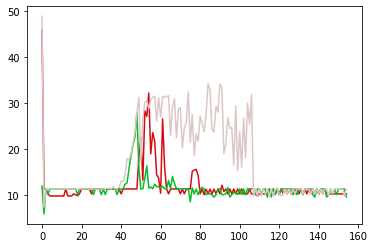

ROUND 154
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300761


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.358248
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.396700
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.384403
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.288330

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302758
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304430
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.416161
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.408031
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334525

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305234
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319952
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.363991
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.384242
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291036
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323225
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.352845
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.321720

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307135
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.331669
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.345841
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337019
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334357

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303657
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.337649
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.408563
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.340217
Model client44 Train Epoch: 5 

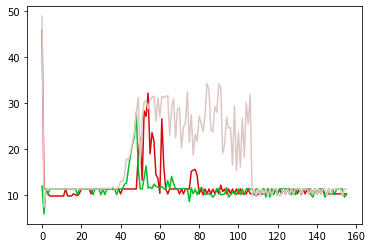

ROUND 155
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302557


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.389804
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.412566
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.407107
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.365285

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300435
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299949
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.375800
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.369481
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.349507

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303300
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.269947
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322112
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.367726
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.326787
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326861
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.319572
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.281574

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302477
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305419
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.369460
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.335308
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.387923

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296232
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310766
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.383090
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.409636
Model client44 Train Epoch: 5 

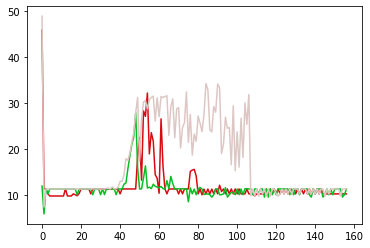

ROUND 156
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302277


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327149
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.450750
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.395054
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.329978

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300104
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328048
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.431599
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.347134
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.407212

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300823
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.329132
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.443525
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328845
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334107
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.274938
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.326534
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314476

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298264
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.351141
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.383339
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.386685
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.307384

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298409
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.280107
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.420433
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.371716
Model client44 Train Epoch: 5 

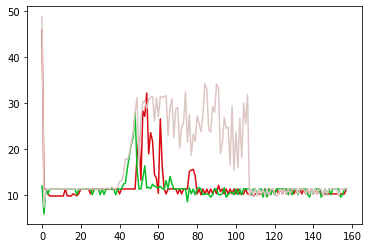

ROUND 157
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298758


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313006
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.423802
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.379726
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.281879

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300946
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.385768
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.280087
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.432353
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.330669

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303247
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.351394
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.411339
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.391247
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304231
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323787
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.336578
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.321748

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300327
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334073
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.363790
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337810
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.349222

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299290
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.358680
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.346954
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.396935
Model client44 Train Epoch: 5 

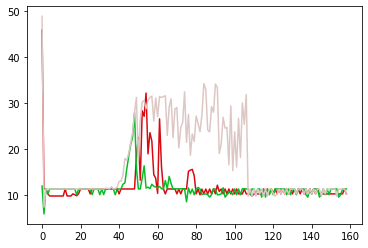

ROUND 158
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302021


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.340003
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.361868
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.468529
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.349799

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304465
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302786
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.287885
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.433449
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.239185

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303119
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.326703
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.325999
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.392269
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325097
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.329506
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317926
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.350440

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304636
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.329079
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317711
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337588
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.298260

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305666
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.363629
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.395021
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328075
Model client44 Train Epoch: 5 

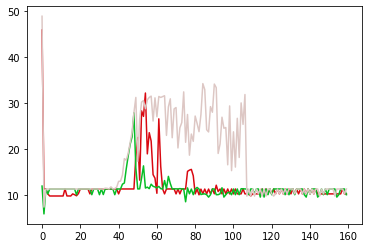

ROUND 159
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304893


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.136250
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.286402
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.371695
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.377394

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304874
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.274963
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.360689
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.382143
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.320138

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304491
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319034
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.353532
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325875
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301361
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.319045
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.346848
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.335117

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303083
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.352560
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.372602
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.389504
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.332458

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301035
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.364862
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.462306
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.353336
Model client44 Train Epoch: 5 

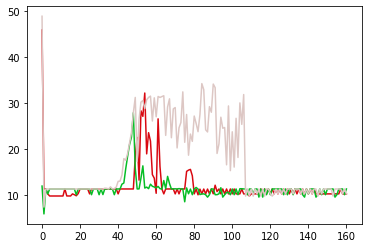

ROUND 160
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301203


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.283028
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.389034
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.342515
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.274401

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306470
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.324723
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.392948
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.401576
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.342371

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303060
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.357974
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.514904
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.358730
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308907
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.351982
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.326215
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.319520

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303662
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303957
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290017
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.393533
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.347698

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303101
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.354748
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.374919
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.432221
Model client44 Train Epoch: 5 

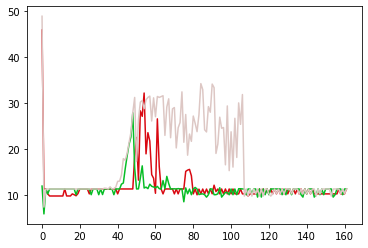

ROUND 161
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308825


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.357751
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378467
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.400434
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.341140

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299608
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298220
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.395880
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.429281
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.308589

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299612
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298345
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.422920
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.335366
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310097
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.328584
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.336463
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.327026

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296423
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.273877
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.392139
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.441385
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.340161

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299906
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.333534
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.417822
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.383571
Model client44 Train Epoch: 5 

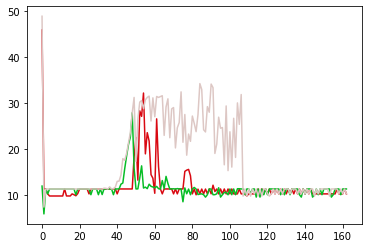

ROUND 162
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296711


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328708
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.388973
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.465321
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.362191

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299502
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299683
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.386422
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.461637
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.338016

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303010
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322603
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.353750
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.432323
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299609
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291226
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328878
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.324014

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300861
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.275848
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.380827
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.391633
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304642

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301347
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.332196
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.379389
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.394903
Model client44 Train Epoch: 5 

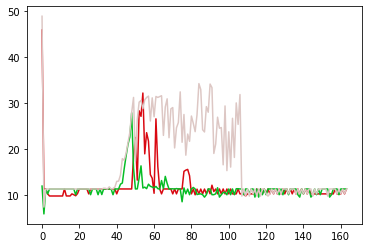

ROUND 163
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304217


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.359867
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330926
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325870
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.337476

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297878
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.337578
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.341729
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.356040
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.323124

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306606
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318954
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.383843
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.419701
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307262
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.309036
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.331180
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.305281

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297915
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.356293
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.372206
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.367279
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.360316

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304735
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.355398
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.492931
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.271017
Model client44 Train Epoch: 5 

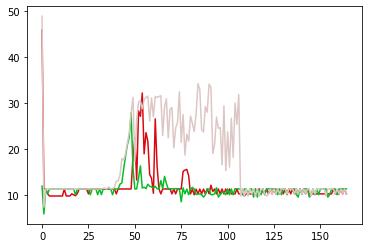

ROUND 164
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298341


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.369757
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.288687
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.395263
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.341237

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304987
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.348790
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.349126
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.376220
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292045

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301168
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.351710
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.418134
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.440393
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.340674
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.334398
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311888
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.294342

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300785
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.370353
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.384000
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.464733
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.408212

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304958
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.279964
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.504855
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.382897
Model client44 Train Epoch: 5 

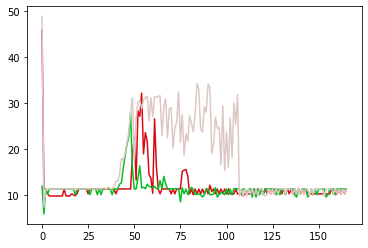

ROUND 165
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298078


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316835
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.397593
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.381292
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.354221

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299690
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334004
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.321796
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.385463
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.311798

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301982
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.350414
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.417652
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.401089
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.324692
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.334726
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.324519
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.279361

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304347
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301710
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.386398
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.389798
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.380283

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306597
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.350756
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.352618
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.290516
Model client44 Train Epoch: 5 

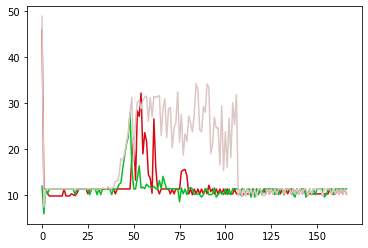

ROUND 166
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301939


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.326433
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293434
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.466225
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.275862

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300148
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.386366
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.400133
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.428400
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.342460

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304201
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.337166
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.428546
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.359503
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307628
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.277988
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.348975
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334896

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305530
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334601
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.414922
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329501
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299789

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302542
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.388518
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.396983
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.498214
Model client44 Train Epoch: 5 

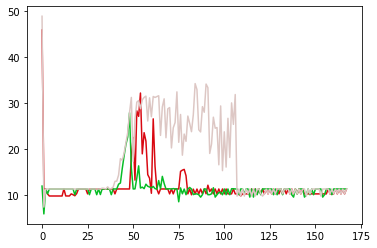

ROUND 167
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303296


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310287
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.390507
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.395451
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.312651

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306869
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314818
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.376435
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.334738
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304476

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300643
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.276711
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.300010
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.419822
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317855
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293614
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.281486
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.336273

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298451
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.373586
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.355008
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.402329
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.296416

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303428
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.339864
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.448832
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.349328
Model client44 Train Epoch: 5 

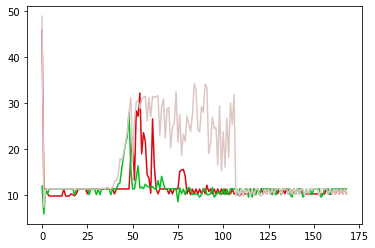

ROUND 168
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302493


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.240131
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.410503
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.374463
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.330350

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302419
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320844
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.287005
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.481204
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.333929

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300649
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319666
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.404835
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.343212
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.281501
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311585
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.336840
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303443

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299666
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290826
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.359123
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.305502
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.368937

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302321
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319172
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308613
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.391811
Model client44 Train Epoch: 5 

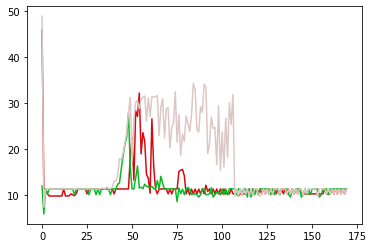

ROUND 169
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299571


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314963
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.382153
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.366709
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.339551

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299379
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301368
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.458502
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.406390
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.342813

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303477
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295984
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.384862
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.388561
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310718
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305968
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.368541
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.282173

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298820
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.359019
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.345769
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330198
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.340754

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301874
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320092
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.370868
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.443283
Model client44 Train Epoch: 5 

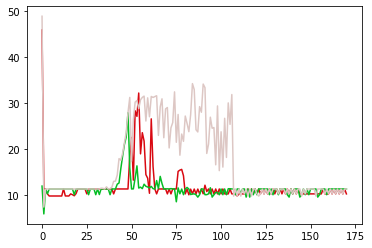

ROUND 170
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297774


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328329
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.398089
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.364870
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.345159

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304044
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294428
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.352044
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.345848
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.337961

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296086
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.345541
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.336027
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.378250
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303087
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.343115
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.354787
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.318933

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306931
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.379045
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.480766
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.375785
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.328470

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308129
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.284689
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.393079
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.421015
Model client44 Train Epoch: 5 

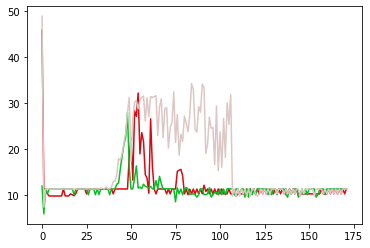

ROUND 171
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299847


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288288
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313928
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.423198
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303666

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308651
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288870
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.284640
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.362998
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.373943

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303710
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.342627
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378810
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.334215
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287532
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.304937
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.358738
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306540

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303792
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.330665
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.333292
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.413768
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299735

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297030
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.340319
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.442101
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.396281
Model client44 Train Epoch: 5 

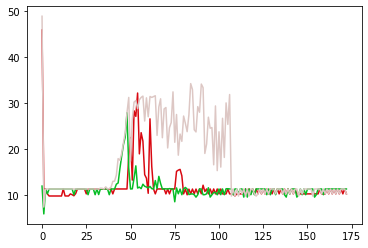

ROUND 172
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303104


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312533
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330622
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.318239
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.377064

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302469
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.331638
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.416906
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.297024
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313164

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297937
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.348108
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.369344
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.400069
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304026
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.340935
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328401
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291357

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300584
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289435
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.416819
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.392543
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.356282

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304580
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.341991
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.434487
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.477988
Model client44 Train Epoch: 5 

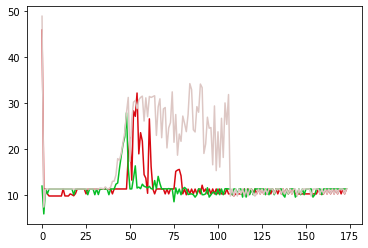

ROUND 173
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300891


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287541
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378435
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.350237
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.347076

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305707
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285509
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.485433
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.360320
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.343328

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303023
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.331634
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.321343
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.358603
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293029
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330606
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308211
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.311627

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301126
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319826
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.376961
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.345506
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.342774

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299307
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334496
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.389859
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.434560
Model client44 Train Epoch: 5 

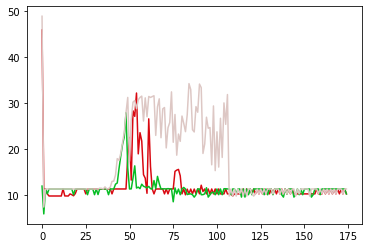

ROUND 174
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301250


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292856
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.372159
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.385323
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.329246

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302224
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295476
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378899
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.386981
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306079

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299574
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.241347
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.396592
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.350121
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320702
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322532
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.366885
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.286359

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299007
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.262767
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.338459
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.420009
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.351416

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294405
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327897
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.416206
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.381847
Model client44 Train Epoch: 5 

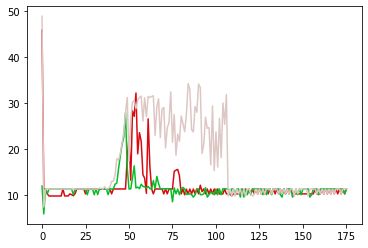

ROUND 175
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300297


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.367654
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.421474
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.458754
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.356216

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303875
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.356440
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.447909
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.303011
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.294081

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300990
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.352259
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302506
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.364819
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325101
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.344401
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.341389
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.321657

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299899
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.364174
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.427864
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.417897
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.341362

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303825
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297139
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.450366
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.371253
Model client44 Train Epoch: 5 

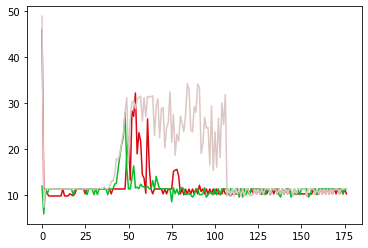

ROUND 176
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304002


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.246920
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.394389
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.296116
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.294530

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299061
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313267
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.372010
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.372679
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.265802

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302213
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334421
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.386119
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.382379
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294982
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.301803
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329249
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302357

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Poor Channel, client not taken for averaging in this round

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303632
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296669
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.342921
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.292607
Model client44 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.361506

Power Allocated= 10.597324054098017
CSI= 0.7090383924773043
SNR= 29.578820033989516
Client: client46
Model client46 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304681
Model client46 Train Epoch: 2 [0/1216 (0%)]	Lo

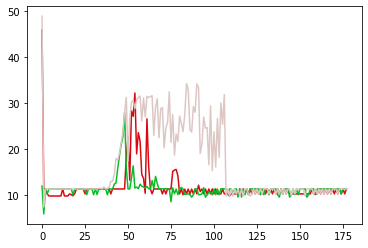

ROUND 177
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300992


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321032
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.348383
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.410219
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.324013

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304494
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.330904
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.386276
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.324271
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.328062

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300052
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.347060
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.374274
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312745
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319028
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.335975
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.339332
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326288

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302336
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.354214
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.393389
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.339307
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.296898

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300993
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.351813
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.445978
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.359792
Model client44 Train Epoch: 5 

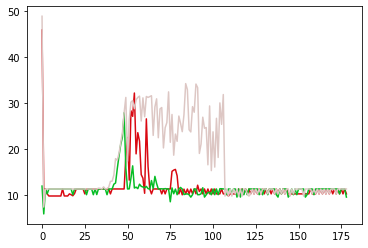

ROUND 178
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297376


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.209122
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314323
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.449460
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315404

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301030
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.354426
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.352664
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.385028
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326630

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304475
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310162
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311987
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.354950
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.344912
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.310803
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317391
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322155

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302776
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302991
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.352395
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.482794
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.345451

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300205
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301817
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.337576
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.278609
Model client44 Train Epoch: 5 

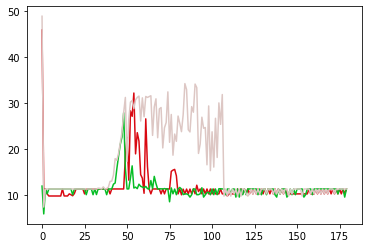

ROUND 179
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304315


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.306270
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.354207
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 32.089138
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.296547

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305182
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314081
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.335126
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.348905
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.352674

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298605
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.351880
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.390967
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.392095
Model client9 Train Epoch: 5 [0/1216 (0%)]	Lo

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292055
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299174
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.324896
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304825

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300042
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307588
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.377466
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.367481
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292747

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302697
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.271376
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.345495
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.319588
Model client44 Train Epoch: 5 

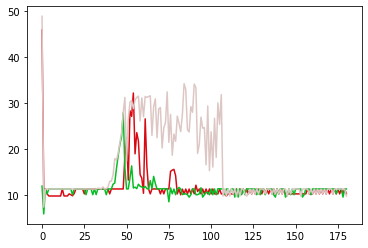

ROUND 180
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299917


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.349691
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.423786
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.454172
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.371872

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305271
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.366201
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.356516
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.380695
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326596

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301573
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.349459
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.366724
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.274441
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323065
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.350303
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308846
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.311772

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301892
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.267992
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.403233
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.349106
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.358777

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304351
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314681
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303047
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.426836
Model client44 Train Epoch: 5 

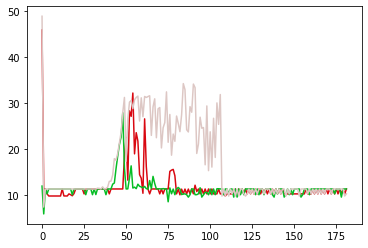

ROUND 181
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298167


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.326159
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.332185
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.322429
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.385358

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309137
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297970
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.403257
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.419006
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.267362

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305660
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291353
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.363989
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.408085
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307261
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.310432
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.314145
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.290883

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297774
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295009
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.396454
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.392125
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.309871

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299498
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316107
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.417495
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.465125
Model client44 Train Epoch: 5 

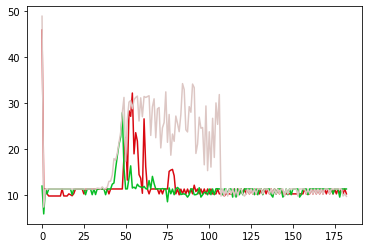

ROUND 182
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300142


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.368618
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.349130
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.491146
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.312689

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302459
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315953
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378868
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.467070
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.355151

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302291
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315248
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.385020
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.388552
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304852
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.258971
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.365414
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.338855

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302065
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.367597
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.389895
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.404665
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.327780

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301817
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.346721
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.328889
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.374814
Model client44 Train Epoch: 5 

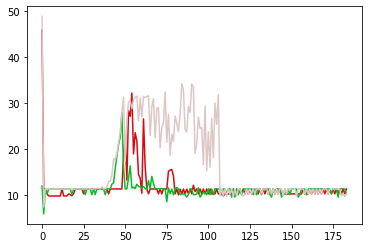

ROUND 183
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301455


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.370880
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.376878
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.276742
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.337387

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305841
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293504
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.467399
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.370849
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.320555

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304178
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.247381
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.372782
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.387957
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.333463
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.320109
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.345642
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.268258

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299570
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.386573
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.434026
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323937
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.321483

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302465
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.274445
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.369339
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.413941
Model client44 Train Epoch: 5 

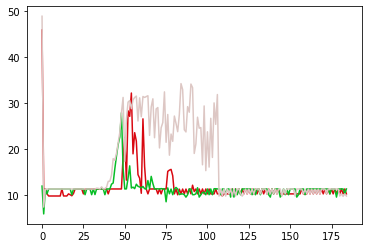

ROUND 184
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300956


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303640
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.332885
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.273445
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314038

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299414
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.364519
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378464
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.264604
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.280337

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298535
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325917
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.402404
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.415049
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317296
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298235
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329835
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302801

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305032
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325937
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.397164
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.376938
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.300281

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302316
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.357520
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.444136
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.269871
Model client44 Train Epoch: 5 

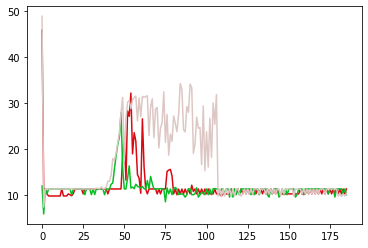

ROUND 185
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299634


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293906
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.460027
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.422468
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.336030

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303437
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298510
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317073
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.382757
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.332582

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295517
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.277402
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.375382
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.362361
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307021
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.349004
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325695
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.323198

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303474
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.367673
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378806
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.346918
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295220

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304281
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.349236
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316868
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.436400
Model client44 Train Epoch: 5 

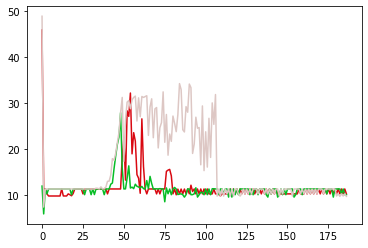

ROUND 186
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301292


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313791
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.403150
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.428094
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.359055

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302657
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.361829
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.382137
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.326967
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.277056

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298992
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317240
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.363068
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.306092
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320471
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305624
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.349823
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315785

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301401
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293112
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.364248
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.383867
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291923

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305287
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.332670
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.354420
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.427780
Model client44 Train Epoch: 5 

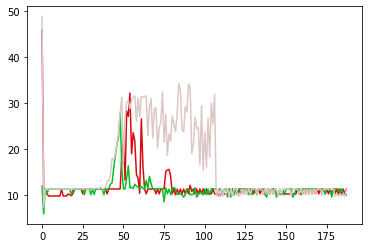

ROUND 187
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302620


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.326372
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.332394
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.456180
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.311046

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307231
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.352054
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.435863
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.348722
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.351866

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303823
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290624
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308828
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.367165
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300483
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.332134
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.316147
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.327120

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304061
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.338391
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.384457
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.399533
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.331793

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304663
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286129
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378503
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.380462
Model client44 Train Epoch: 5 

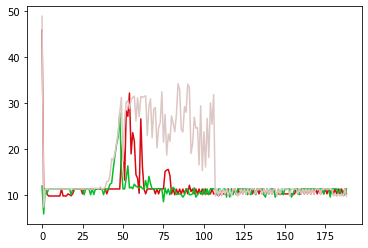

ROUND 188
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305866


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310621
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.331347
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.324005
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.390418

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301187
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.275389
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.332743
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.387679
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.382989

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301698
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.338063
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.325118
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.400126
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328300
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317081
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.304708
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334034

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301558
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.358305
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.438177
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.357563
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.388782

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302551
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.336308
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.432816
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.366598
Model client44 Train Epoch: 5 

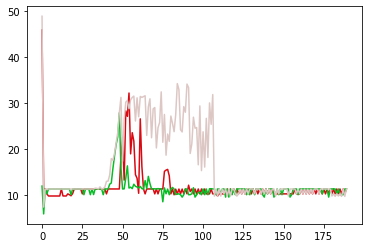

ROUND 189
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296266


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305269
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.420093
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.370022
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.382108

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299609
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327565
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.363954
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.438440
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316129

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294539
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.339664
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.304857
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.390927
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322696
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290298
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.364280
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310486

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301131
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.354820
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.427207
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.411374
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.425977

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304776
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.346740
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.434073
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.327157
Model client44 Train Epoch: 5 

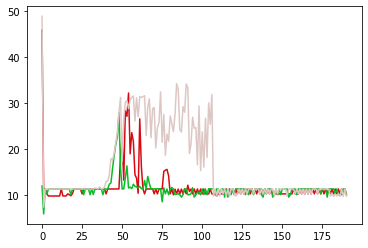

ROUND 190
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294935


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.386796
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299344
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.442078
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.284917

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303898
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.330894
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.370792
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.402138
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.421716

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300508
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.347051
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.374436
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.380607
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.351840
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.280628
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.368342
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.298388

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307620
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.372009
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.370538
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.348038
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317476

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299706
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.335487
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.401240
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.463709
Model client44 Train Epoch: 5 

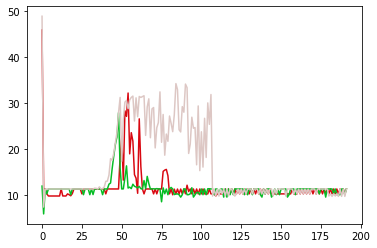

ROUND 191
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295613


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.277102
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.376625
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.399299
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.380625

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300319
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315823
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.373440
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.345087
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.318104

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301885
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319670
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.466210
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325958
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318096
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.297488
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.293345
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.336744

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293248
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.362530
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.431659
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.410490
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.339192

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297756
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304763
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.390051
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.376889
Model client44 Train Epoch: 5 

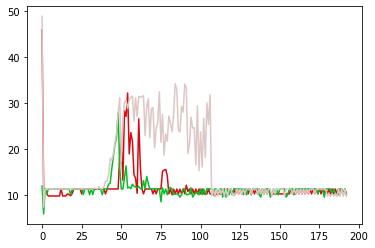

ROUND 192
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307060


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.362381
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.374160
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.355076
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.347206

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299263
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.347585
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.373666
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.385755
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.333911

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300400
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.337938
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.287986
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.382708
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.339675
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.284134
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.345244
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314069

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304193
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.354924
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.390245
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.421242
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297387

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303879
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.384219
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.386501
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.416701
Model client44 Train Epoch: 5 

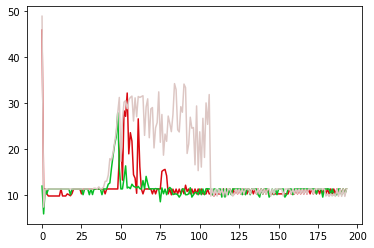

ROUND 193
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302942


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.332586
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296761
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.347054
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.320611

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300979
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.264924
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.361482
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337137
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299769

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304867
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299443
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.377252
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.346534
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.339040
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323671
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.282995
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.276197

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307551
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.346402
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318310
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.387130
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.335975

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300307
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.395963
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330013
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.389315
Model client44 Train Epoch: 5 

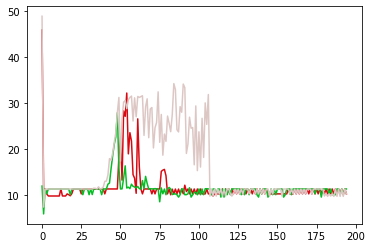

ROUND 194
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302336


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307507
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.341640
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.516544
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.359435

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307113
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.347604
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.382567
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.363078
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.327589

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301579
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289112
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.337204
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.252876
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.273628
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.367214
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.322944
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.281357

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302316
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285079
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.352105
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.339100
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.359275

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300816
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.263313
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.395643
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329622
Model client44 Train Epoch: 5 

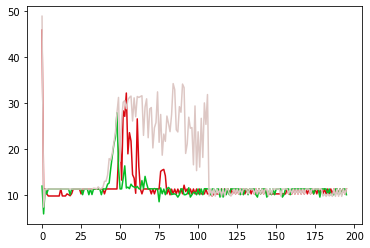

ROUND 195
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305946


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.333575
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.362817
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.414685
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.305792

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299559
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321123
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.320583
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.405620
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.352613

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296704
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305764
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.422362
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.384699
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299464
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312885
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312634
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.369042

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303486
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.336703
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.444969
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.388719
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.345244

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298052
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.348564
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.436958
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.487456
Model client44 Train Epoch: 5 

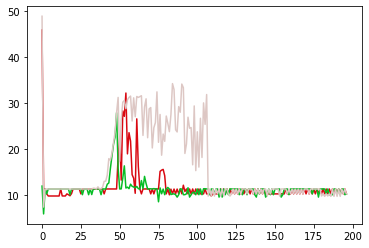

ROUND 196
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304389


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310404
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.343490
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.434795
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.362216

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301178
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295149
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.393807
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.352369
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.301144

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302590
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.344768
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305060
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.473976
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327229
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296176
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.365611
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303611

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302145
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305581
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.382212
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.249074
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303105

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299252
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323644
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.346303
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.441021
Model client44 Train Epoch: 5 

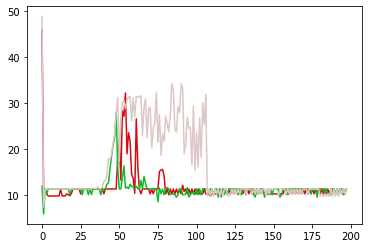

ROUND 197
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298888


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.341463
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.289016
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.369453
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.347801

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300035
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.366842
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.344069
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.342085
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.388822

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302943
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.339301
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.366914
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.388052
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297368
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.319296
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.302653
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299073

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304289
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321527
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312474
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.457272
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.393060

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298371
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.368632
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.461868
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.450760
Model client44 Train Epoch: 5 

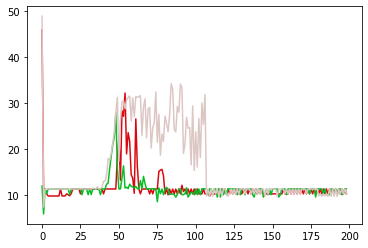

ROUND 198
0.08328000000000516
Power Allocated= 3.0971402196998667
CSI= 0.11222658477341207
SNR= 48.110370422318056
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295515


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.333354
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290959
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.457943
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.372500

Power Allocated= 7.373183417799669
CSI= 0.21577293693440402
SNR= 23.800770085666215
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302040
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325542
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.356682
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.413919
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.340182

Power Allocated= 6.96136800457265
CSI= 0.19816432798154537
SNR= 28.34279309471531
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298724
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285060
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.385279
Model client9 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.404781
Model client9 Train Epoch: 5 [0/1216 (0%)]	Los

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client34 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288536
Model client34 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326167
Model client34 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308253
Model client34 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297529

Power Allocated= 10.727352125748808
CSI= 0.7810469323141298
SNR= 25.438881272920028
Client: client40
Model client40 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300571
Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.284249
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.410014
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.407717
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.336949

Power Allocated= 10.259977934753186
CSI= 0.5721782938371616
SNR= 32.55079265152951
Client: client44
Model client44 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304426
Model client44 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.273033
Model client44 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.382371
Model client44 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.422381
Model client44 Train Epoch: 5 

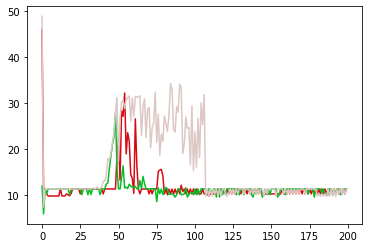

ROUND 199


In [14]:
for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)

final_acc=[]
final_loss=[]
clor = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(args.numclusters)]   
for fed_round in range(args.rounds):
    overall=Net()
    if(fed_round==0): #fed_round==0
        arranged_clusters,head_snr_list=cluster_former(args.numclusters,args.clients)
        temp=deepcopy(arranged_clusters)
        temp2=deepcopy(head_snr_list)
    else:
        #print(temp)
        arranged_clusters=deepcopy(temp)
        head_snr_list=deepcopy(temp2)
#     print(arranged_clusters)
    
    no=1
    heads_list=[]
    weights=[]
    weight_head_list=[]
    head_acc=[]
    head_loss=[]
    for cluster in arranged_clusters:
        
        head=cluster['Cluster Head']
        members=cluster['Members']
        snrs=cluster['SNR']
        csis=cluster['CSI']
        weights.append(sum(snrs))
        weight_head_list.append([head,sum(snrs)])
        new_members=[]
        
        for ij in members:
        #print(ij)
            cl_no=int(ij[6:])
            new_members.append(clients[cl_no-1])
#         print(head)
        head=clients[int(head[6:])-1]
        cluster['Members']=new_members
#         print(head)

        smallmu1=0
        gsmall1=3.402823466E+38 
        
        #water filling algorithm
        mu=1e-15
        while(mu<=1):
            g1=0
            pn1=0
            for jj in csis:
                pn=max(1/mu-1/jj,0)
                g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
                pn1+=pn
            g=g1-mu*(pn1-P*30)
            if(g<gsmall1):
                smallmu1=mu
                gsmall1=g
            mu+=0.00002
        
        print(smallmu1)
        good_mem=[]
#         print(len(snrs))
#         print(len(csis))
#         print(len(new_members))
        index=0
        for client in new_members:
            goodchannel=ClientUpdate(args, device, client,key_np,key,snrs[index],csis[index],smallmu1,head)
            index+=1
            if(goodchannel):
                good_mem.append(client)
        
        head['model']=averageModels(head['model'], good_mem)
        arr=test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)
        ac=arr[0]#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[0]
        no+=1
        heads_list.append(head)
        head_acc.append(ac)
        head_loss.append(arr[1])#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[1])
    
    final_acc.append(head_acc)
    final_loss.append(head_loss)
    fig,ax=plt.subplots()
    
    #ax.plot([i for i in range(fed_round)],head_acc[0])
    for jj in range(0,args.numclusters):
        
        ax.plot([i for i in range(len(final_acc))],[final_acc[j][jj] for j in range(len(final_acc))], color = clor[jj])
        
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][0] for j in range(len(final_acc))], color ="red")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][1] for j in range(len(final_acc))],color ="blue")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][2] for j in range(len(final_acc))],color ="green")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][3] for j in range(len(final_acc))],color ="black")
    #ax.plot([i for i in range(len(final_acc))],head_acc[1], fed_round, color ="blue")
    #ax.plot([i for i in range(len(final_acc))],head_acc[2], fed_round, color ="green")
    #ax.plot([i for i in range(len(final_acc))],head_acc[3], fed_round, color ="black")
    
    
    plt.show()
    weightsum=sum(weights)
    
    weights[:] = [x / weightsum for x in weights]
    for aah in range(len(weight_head_list)):
        weight_head_list[aah][1]=weights[aah]
    final_heads,nets=decentralized(heads_list,head_snr_list,weight_head_list)
    
    for head in range(len(final_heads)):
        for cluster in arranged_clusters:
            head1=cluster['Cluster Head']
            if(head1==final_heads[head]['hook'].id):
                for mem in cluster['Members']:
                    mem['model'].load_state_dict(nets[head].state_dict())
    print("ROUND",fed_round)

In [15]:
print(final_acc)

[[45.95, 11.98, 48.94], [11.4, 5.92, 7.41], [11.35, 11.35, 11.35], [10.28, 10.28, 11.35], [9.82, 11.35, 11.35], [9.82, 11.35, 11.35], [9.82, 11.35, 11.35], [9.82, 11.35, 11.35], [9.82, 11.35, 11.35], [9.82, 11.35, 11.35], [9.82, 11.35, 11.35], [9.82, 11.35, 11.35], [11.37, 11.35, 11.35], [9.83, 11.35, 11.35], [9.82, 11.35, 11.35], [9.82, 11.35, 11.35], [10.28, 11.35, 11.35], [10.1, 11.35, 11.35], [9.87, 10.1, 11.35], [10.35, 11.35, 11.35], [11.35, 11.35, 11.35], [11.36, 11.35, 11.35], [11.35, 11.35, 11.35], [11.35, 11.35, 11.35], [11.35, 11.35, 11.35], [10.28, 11.35, 11.35], [11.35, 10.1, 11.35], [11.35, 11.35, 11.35], [11.35, 11.35, 11.35], [11.35, 11.35, 11.35], [11.35, 10.1, 11.35], [11.35, 11.35, 11.35], [11.35, 10.13, 11.35], [11.35, 11.39, 11.52], [11.35, 11.35, 11.49], [11.35, 11.36, 11.35], [11.35, 11.37, 11.81], [11.35, 11.35, 11.35], [11.35, 10.1, 11.44], [11.35, 11.35, 11.74], [10.28, 11.35, 13.0], [11.35, 11.35, 13.06], [11.35, 12.39, 14.38], [11.35, 12.65, 17.95], [11.35, 